**This notebook introduces how to train a convolutional neural network to predict sea ice extent from SST data. <br/>**

Based on HadISST SST and Ice data

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import urllib.request
import gzip
import shutil
import cartopy.crs as ccrs
import torch
import torch.nn as nn

from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Define data paths and directories
cwd = os.getcwd()
data_dir = Path("hadisst_data")
data_dir.mkdir(exist_ok=True)

### 0. Data Download: Download and prepare HadISST SST + ICE data

In [4]:
sst_url = "https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_sst.nc.gz"
ice_url = "https://www.metoffice.gov.uk/hadobs/hadisst/data/HadISST_ice.nc.gz"

sst_gz = data_dir / "HadISST_sst.nc.gz"
ice_gz = data_dir / "HadISST_ice.nc.gz"
sst_nc = data_dir / "HadISST_sst.nc"
ice_nc = data_dir / "HadISST_ice.nc"

def download_if_needed(url, gz_path):
    if not gz_path.exists():
        print(f"  - Downloading {gz_path.name} ...")
        urllib.request.urlretrieve(url, gz_path)
    else:
        print(f"  - {gz_path.name} already exists, skipping download.")

def gunzip_if_needed(gz_path, nc_path):
    if not nc_path.exists():
        print(f"  - Decompressing {gz_path.name} -> {nc_path.name}")
        with gzip.open(gz_path, "rb") as f_in, open(nc_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
    else:
        print(f"  - {nc_path.name} already exists, skipping decompression.")

download_if_needed(sst_url, sst_gz)
gunzip_if_needed(sst_gz, sst_nc)

download_if_needed(ice_url, ice_gz)
gunzip_if_needed(ice_gz, ice_nc)


ds_sst = xr.open_dataset(sst_nc)
ds_ice = xr.open_dataset(ice_nc)

if "sic" in ds_ice.data_vars:
    ice_var = "sic"
elif "ice" in ds_ice.data_vars:
    ice_var = "ice"
else:
    ice_var = list(ds_ice.data_vars)[0]
    print(f"Using '{ice_var}' as the ice variable (first data_var).")

# Merge into a single dataset with variables 'sst' and 'ice'
ds_full = xr.merge([
    ds_sst[["sst"]],                            
    ds_ice[[ice_var]].rename({ice_var: "ice"}) 
])


# Filter to only include Arctic (lat > 45) and Antarctic (lat < -45), DROP non-polar
ds_full = ds_full.where(
    (ds_full.latitude > 45) | (ds_full.latitude < -45),
    drop=True
)

print(f"\nFiltered dataset to polar regions:")
print(f"  Latitude range: {ds_full.latitude.min().values:.2f}° to {ds_full.latitude.max().values:.2f}°")
print(f"  Number of latitude points: {len(ds_full.latitude)}")

  - HadISST_sst.nc.gz already exists, skipping download.
  - HadISST_sst.nc already exists, skipping decompression.
  - HadISST_ice.nc.gz already exists, skipping download.
  - HadISST_ice.nc already exists, skipping decompression.

Filtered dataset to polar regions:
  Latitude range: -89.50° to 89.50°
  Number of latitude points: 90


### 1. Data preprocessing: prepare data for training & test sets

In [6]:

# 1. DATA PREPROCESSING: full maps (time, 1, H_polar, W)
print("STEP 1: DATA PREPROCESSING")
print("\nSplitting data into train, validation, and test sets")

train_end_year  = '2000'
val_start_year  = '2000'
val_end_year    = '2010'
test_start_year = '2010'
test_end_year   = '2025'


# 1.1 Time and data splits (still all global)
ds_train = ds_full.sel(time=slice(None, train_end_year))
ds_val   = ds_full.sel(time=slice(val_start_year, val_end_year))
ds_test  = ds_full.sel(time=slice(test_start_year, test_end_year))

print(f"Training data time range:    {ds_train.time.values[0]} to {ds_train.time.values[-1]}")
print(f"Validation data time range:  {ds_val.time.values[0]}   to {ds_val.time.values[-1]}")
print(f"Testing data time range:     {ds_test.time.values[0]}  to {ds_test.time.values[-1]}")
print(f"Training samples (time): {len(ds_train.time)}")
print(f"Validation samples (time): {len(ds_val.time)}")
print(f"Testing samples (time): {len(ds_test.time)}")


# 1.2 restrict to polar latitudes only (lat > 45)
lat_vals = ds_full.latitude.values
polar_mask = (lat_vals >= 45) | (lat_vals <= -45)

ds_train = ds_train.sel(latitude=lat_vals[polar_mask])
ds_val   = ds_val.sel(latitude=lat_vals[polar_mask])
ds_test  = ds_test.sel(latitude=lat_vals[polar_mask])

lat = ds_train.latitude.values
lon = ds_train.longitude.values

print("\nUsing polar latitudes only.")
print("Number of latitude points:", lat.shape[0])
print("Latitude range:", float(lat.min()), "to", float(lat.max()))


# 1.3 SST (X) and ICE (y) as 3-D arrays: (time, lat, lon)
print("Preparing predictor (X: SST) and target (y: ICE) as polar maps")

X_train_np = ds_train['sst'].values
X_val_np   = ds_val['sst'].values
X_test_np  = ds_test['sst'].values

y_train_np = ds_train['ice'].values
y_val_np   = ds_val['ice'].values
y_test_np  = ds_test['ice'].values

print(f"Raw X_train shape: {X_train_np.shape}")
print(f"Raw y_train shape: {y_train_np.shape}")

print("\nNaN counts before any processing:")
print(f"  X_train NaNs: {np.isnan(X_train_np).sum()}")
print(f"  y_train NaNs: {np.isnan(y_train_np).sum()}")
print(f"  X_val   NaNs: {np.isnan(X_val_np).sum()}")
print(f"  y_val   NaNs: {np.isnan(y_val_np).sum()}")
print(f"  X_test  NaNs: {np.isnan(X_test_np).sum()}")
print(f"  y_test  NaNs: {np.isnan(y_test_np).sum()}")


# 1.4 Normalization of SST
print("Normalizing SST (X)")

mean = np.nanmean(X_train_np)
std  = np.nanstd(X_train_np)

if np.isnan(mean) or np.isnan(std) or std == 0:
    raise ValueError(
        f"Bad normalization stats: mean={mean}, std={std}. "
        "Check your time ranges and ds_full contents."
    )

X_train_np = (X_train_np - mean) / std
X_val_np   = (X_val_np   - mean) / std
X_test_np  = (X_test_np  - mean) / std

print(f"SST mean (train, nanmean): {mean}")
print(f"SST std  (train, nanstd):  {std}")


# 1.5 Replace remaining NaNs with 0 (land / missing)
print("\nReplacing remaining NaNs with 0 (just in case)")

X_train_np = np.nan_to_num(X_train_np, nan=0.0)
X_val_np   = np.nan_to_num(X_val_np,   nan=0.0)
X_test_np  = np.nan_to_num(X_test_np,  nan=0.0)

y_train_np = np.nan_to_num(y_train_np, nan=0.0)
y_val_np   = np.nan_to_num(y_val_np,   nan=0.0)
y_test_np  = np.nan_to_num(y_test_np,  nan=0.0)

print("NaN counts after replacement:")
print(f"  X_train NaNs: {np.isnan(X_train_np).sum()}")
print(f"  y_train NaNs: {np.isnan(y_train_np).sum()}")
print(f"  X_val   NaNs: {np.isnan(X_val_np).sum()}")
print(f"  y_val   NaNs: {np.isnan(y_val_np).sum()}")
print(f"  X_test  NaNs: {np.isnan(X_test_np).sum()}")
print(f"  y_test  NaNs: {np.isnan(y_test_np).sum()}")


# 1.6 Add a channel dimension: (time, 1, H, W)
X_train = X_train_np[:, np.newaxis, :, :]
X_val   = X_val_np[:,   np.newaxis, :, :]
X_test  = X_test_np[:,  np.newaxis, :, :]

y_train = y_train_np[:, np.newaxis, :, :]
y_val   = y_val_np[:,   np.newaxis, :, :]
y_test  = y_test_np[:,  np.newaxis, :, :]

print("\nFinal array shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape},  y_test:  {y_test.shape}")

STEP 1: DATA PREPROCESSING

Splitting data into train, validation, and test sets
Training data time range:    1870-01-16T11:59:59.505615234 to 2000-12-16T12:00:00.000000000
Validation data time range:  2000-01-16T12:00:00.000000000   to 2010-12-16T12:00:00.000000000
Testing data time range:     2010-01-16T12:00:00.000000000  to 2025-10-16T12:00:00.000000000
Training samples (time): 1572
Validation samples (time): 132
Testing samples (time): 190

Using polar latitudes only.
Number of latitude points: 90
Latitude range: -89.5 to 89.5
Preparing predictor (X: SST) and target (y: ICE) as polar maps
Raw X_train shape: (1572, 90, 360)
Raw y_train shape: (1572, 90, 360)

NaN counts before any processing:
  X_train NaNs: 21184272
  y_train NaNs: 21184272
  X_val   NaNs: 1778832
  y_val   NaNs: 1778832
  X_test  NaNs: 2560440
  y_test  NaNs: 2560440
Normalizing SST (X)
SST mean (train, nanmean): -75.37638854980469
SST std  (train, nanstd):  268.1572570800781

Replacing remaining NaNs with 0 (jus

### 2. Define the CNN architecture


The CNN architecture used here consists of several upsampling blocks. 

In [7]:
n_filters  = 32
n_neurons  = 64
activation     = 'ReLU' # activation function
kernel_size    = 4
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 50

In [8]:
def make_CNN_model(in_channels, n_filters, activation, kernel_size=None):

    act = getattr(nn, activation)

    layers = [
        nn.Conv2d(in_channels, n_filters, kernel_size=3, padding=1),
        act(),
        nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1),
        act(),
        nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1),
        act(),
        nn.Conv2d(n_filters, 1, kernel_size=1)
    ]

    return nn.Sequential(*layers)

In [9]:
model_mse = make_CNN_model(X_train.shape[1], n_filters, activation, kernel_size)

In [10]:
print("Model:")
print(model_mse)
print(f"\nTotal parameters: {sum(p.numel() for p in model_mse.parameters())}")

Model:
Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
)

Total parameters: 18849


### 3. Train & save the CNN model

In [11]:
def pytorch_train(model, optimizer, criterion, device):
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 20
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
       # training
       model.train()
       train_loss = 0.0
       for batch_X, batch_y in train_loader:
           batch_X = batch_X.to(device)
           batch_y = batch_y.to(device)
           # forward pass
           optimizer.zero_grad()
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           # backward pass
           loss.backward()
           optimizer.step()
           train_loss += loss.item()
    
        # validation
       model.eval()
       val_loss = 0.0
       with torch.no_grad():
           for batch_X, batch_y in val_loader:
               batch_X = batch_X.to(device)
               batch_y = batch_y.to(device)
               
               outputs = model(batch_X)
               loss = criterion(outputs, batch_y)
               val_loss += loss.item()
       
       train_loss /= len(train_loader)
       val_loss /= len(val_loader)
    
       train_losses.append(train_loss)
       val_losses.append(val_loss)
       
       print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
       
       if val_loss < best_val_loss:
           best_val_loss = val_loss
           patience_counter = 0
       else:
           patience_counter += 1
           if patience_counter >= patience:
               print(f'Early stopping at epoch {epoch+1}')
               break
   
    return train_losses, val_losses

In [12]:
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()

X_val_t = torch.from_numpy(X_val).float()
y_val_t = torch.from_numpy(y_val).float()

# Create datasets
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset   = TensorDataset(X_val_t, y_val_t)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=minibatch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=minibatch_size,
    shuffle=False
)


In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [14]:
optimizer_mse = torch.optim.Adam(model_mse.parameters(), lr=learning_rate)

mse_loss = nn.MSELoss()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_losses_mse, val_losses_mse = pytorch_train(model_mse.to(device), optimizer_mse, criterion = mse_loss, device = device)

Epoch 1/50, Train Loss: 0.1088, Val Loss: 0.0879


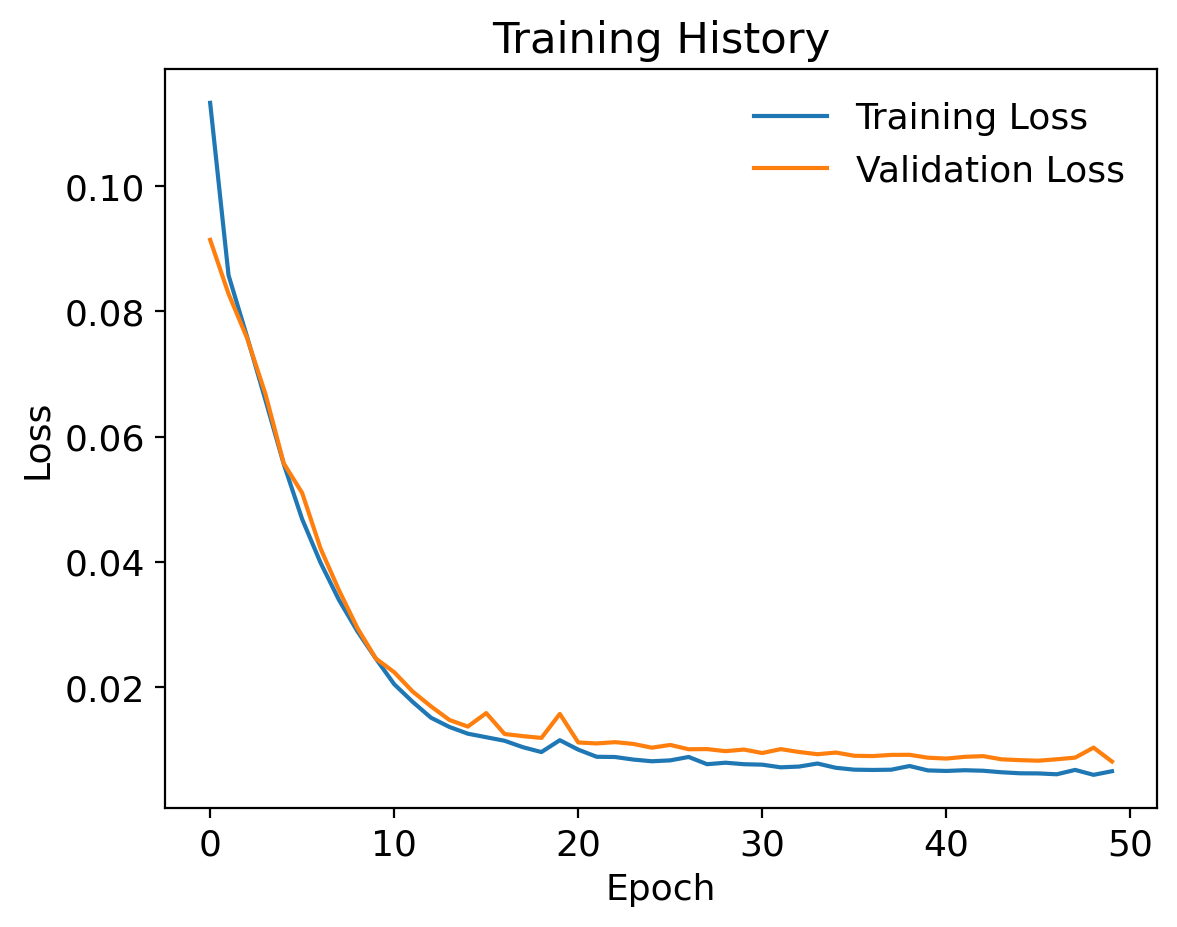

In [134]:
plot_history(train_losses_mse, val_losses_mse)

In [155]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [156]:
torch.save(model_mse.state_dict(), os.path.join(model_path,'HADISST6_model_mse_weights.pth'))

### 4. Evaluate the trained model

In [157]:
# make new model instances for evaluation (best practice)
model_mse_eval = make_CNN_model(X_train.shape[1], n_filters, activation, kernel_size)

# reload the saved model weights
state_dict_mse = torch.load(os.path.join(model_path,'HADISST6_model_mse_weights.pth'), weights_only=True)
model_mse_eval.load_state_dict(state_dict_mse)

<All keys matched successfully>

In [158]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Get lat/lon from dataset
lat = ds_full.latitude.values
lon = ds_full.longitude.values

def compute_year_predictions(year, model, X_data, y_data, ds_data, device):
    times = ds_data.time
    mask = (times.dt.year == year)
    idx = np.where(mask.values)[0]

    if len(idx) == 0:
        print(f"No data found for year {year} in ds_test.")
        return None, None

    X_year = X_data[idx]
    y_year = y_data[idx]

    model = model.to(device)
    model.eval()
    with torch.no_grad():
        inputs = torch.from_numpy(X_year).float().to(device)
        outputs = model(inputs)
        outputs = outputs.cpu().numpy()

    pred_mean = outputs.mean(axis=0).squeeze()
    truth_mean = y_year.mean(axis=0).squeeze()

    return pred_mean, truth_mean

In [24]:
def plot_year_maps(year, model, X_data, y_data, ds_data, lat, lon, device):

    pred_mean, truth_mean = compute_year_predictions(
        year, model, X_data, y_data, ds_data, device
    )
    if pred_mean is None:
        return

    lon2d, lat2d = np.meshgrid(lon, lat)

    vmin = min(pred_mean.min(), truth_mean.min())
    vmax = max(pred_mean.max(), truth_mean.max())

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    # Truth map
    im0 = axes[0].pcolormesh(lon2d, lat2d, truth_mean,
                             shading='auto', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Truth ICE ({year} annual mean)")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    # Prediction map
    im1 = axes[1].pcolormesh(lon2d, lat2d, pred_mean,
                             shading='auto', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Predicted ICE (MSE model, {year} mean)")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    cbar = fig.colorbar(im1, ax=axes[:], location='right', fraction=0.02, pad=0.02)
    cbar.set_label("Sea ice concentration")

    plt.suptitle(f"Sea Ice Concentration: Truth vs Prediction ({year})", fontsize=14)
    plt.show()


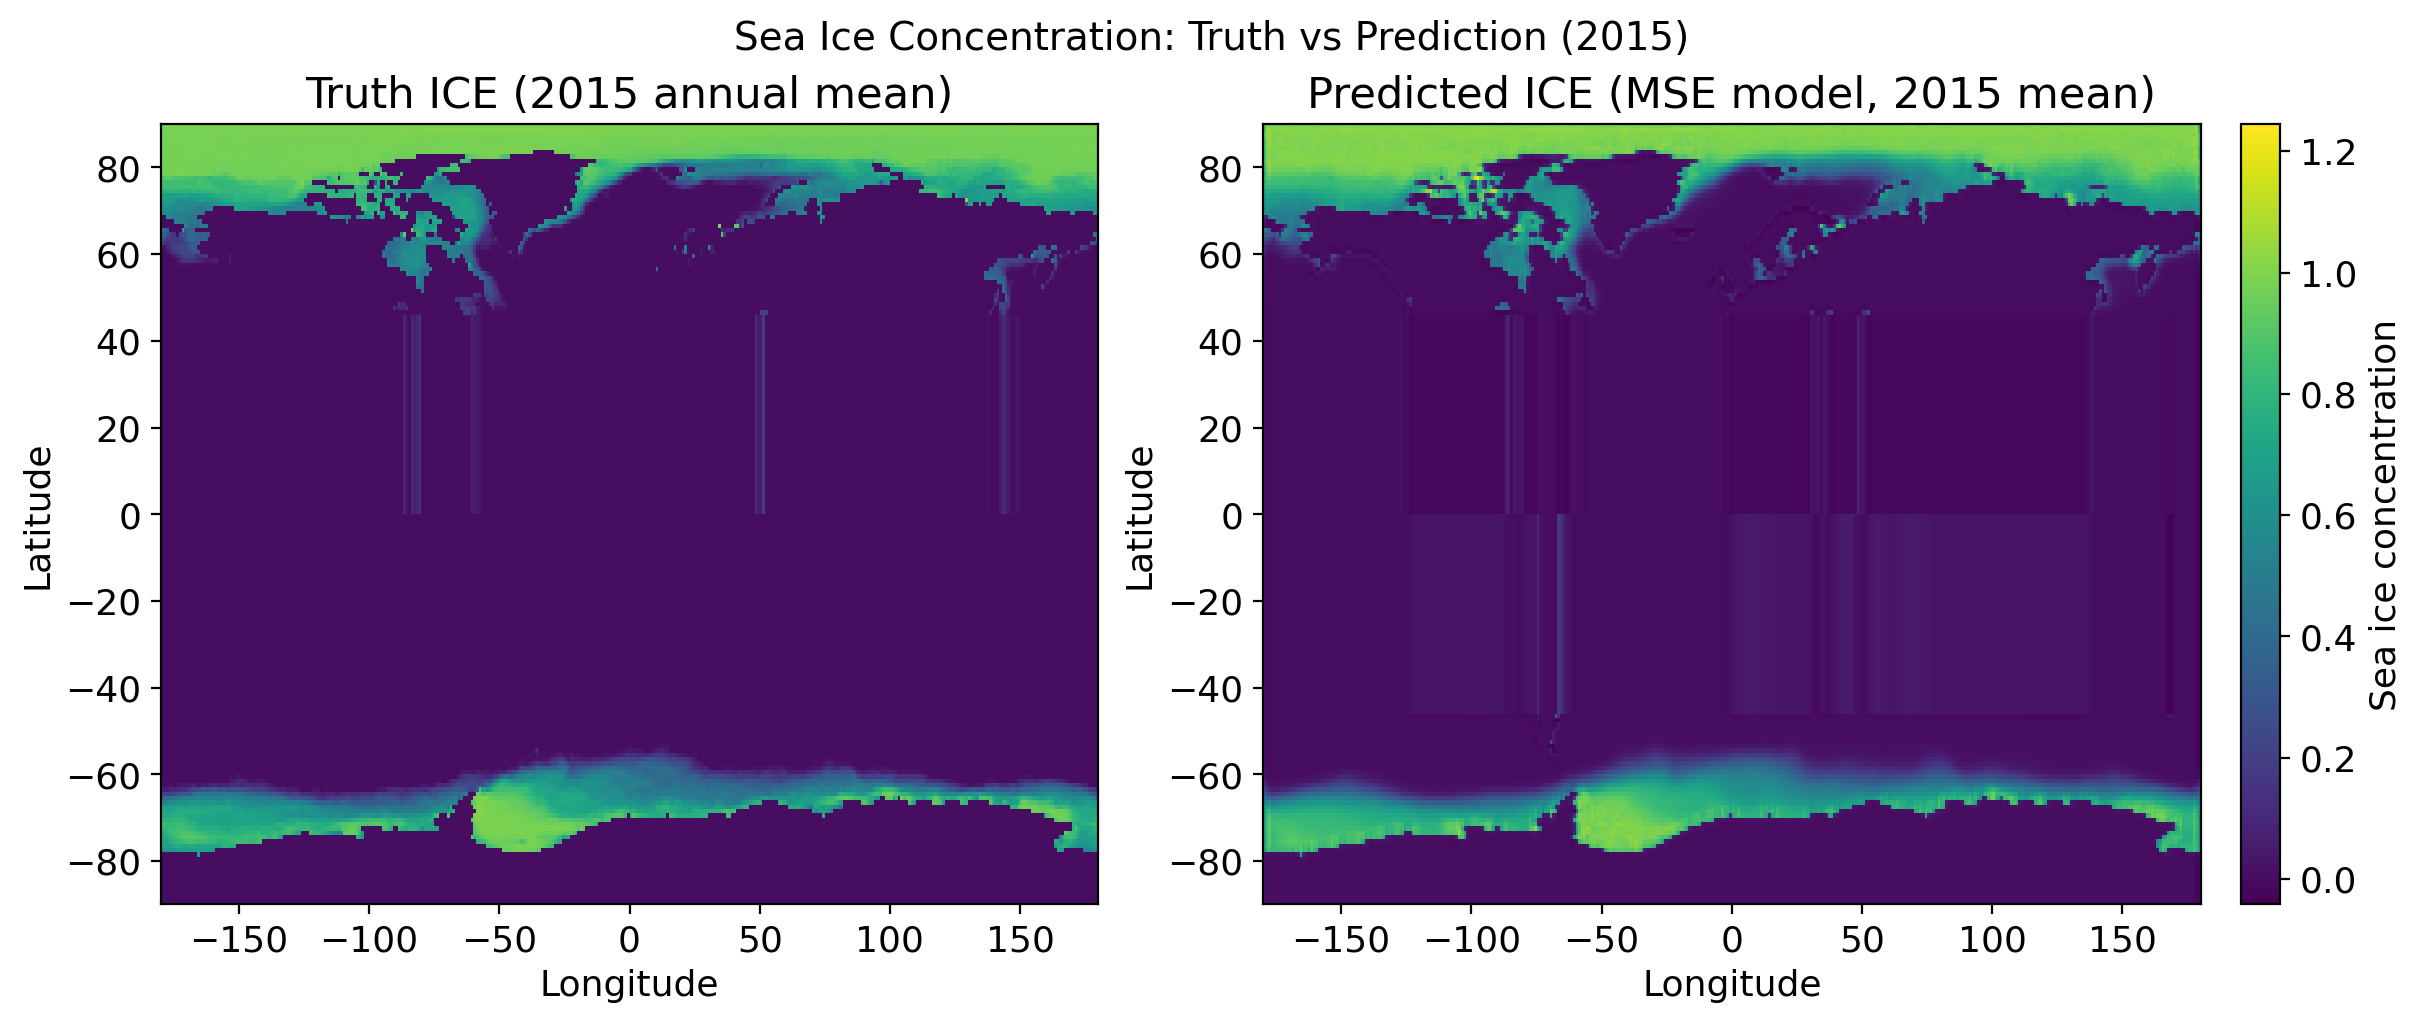

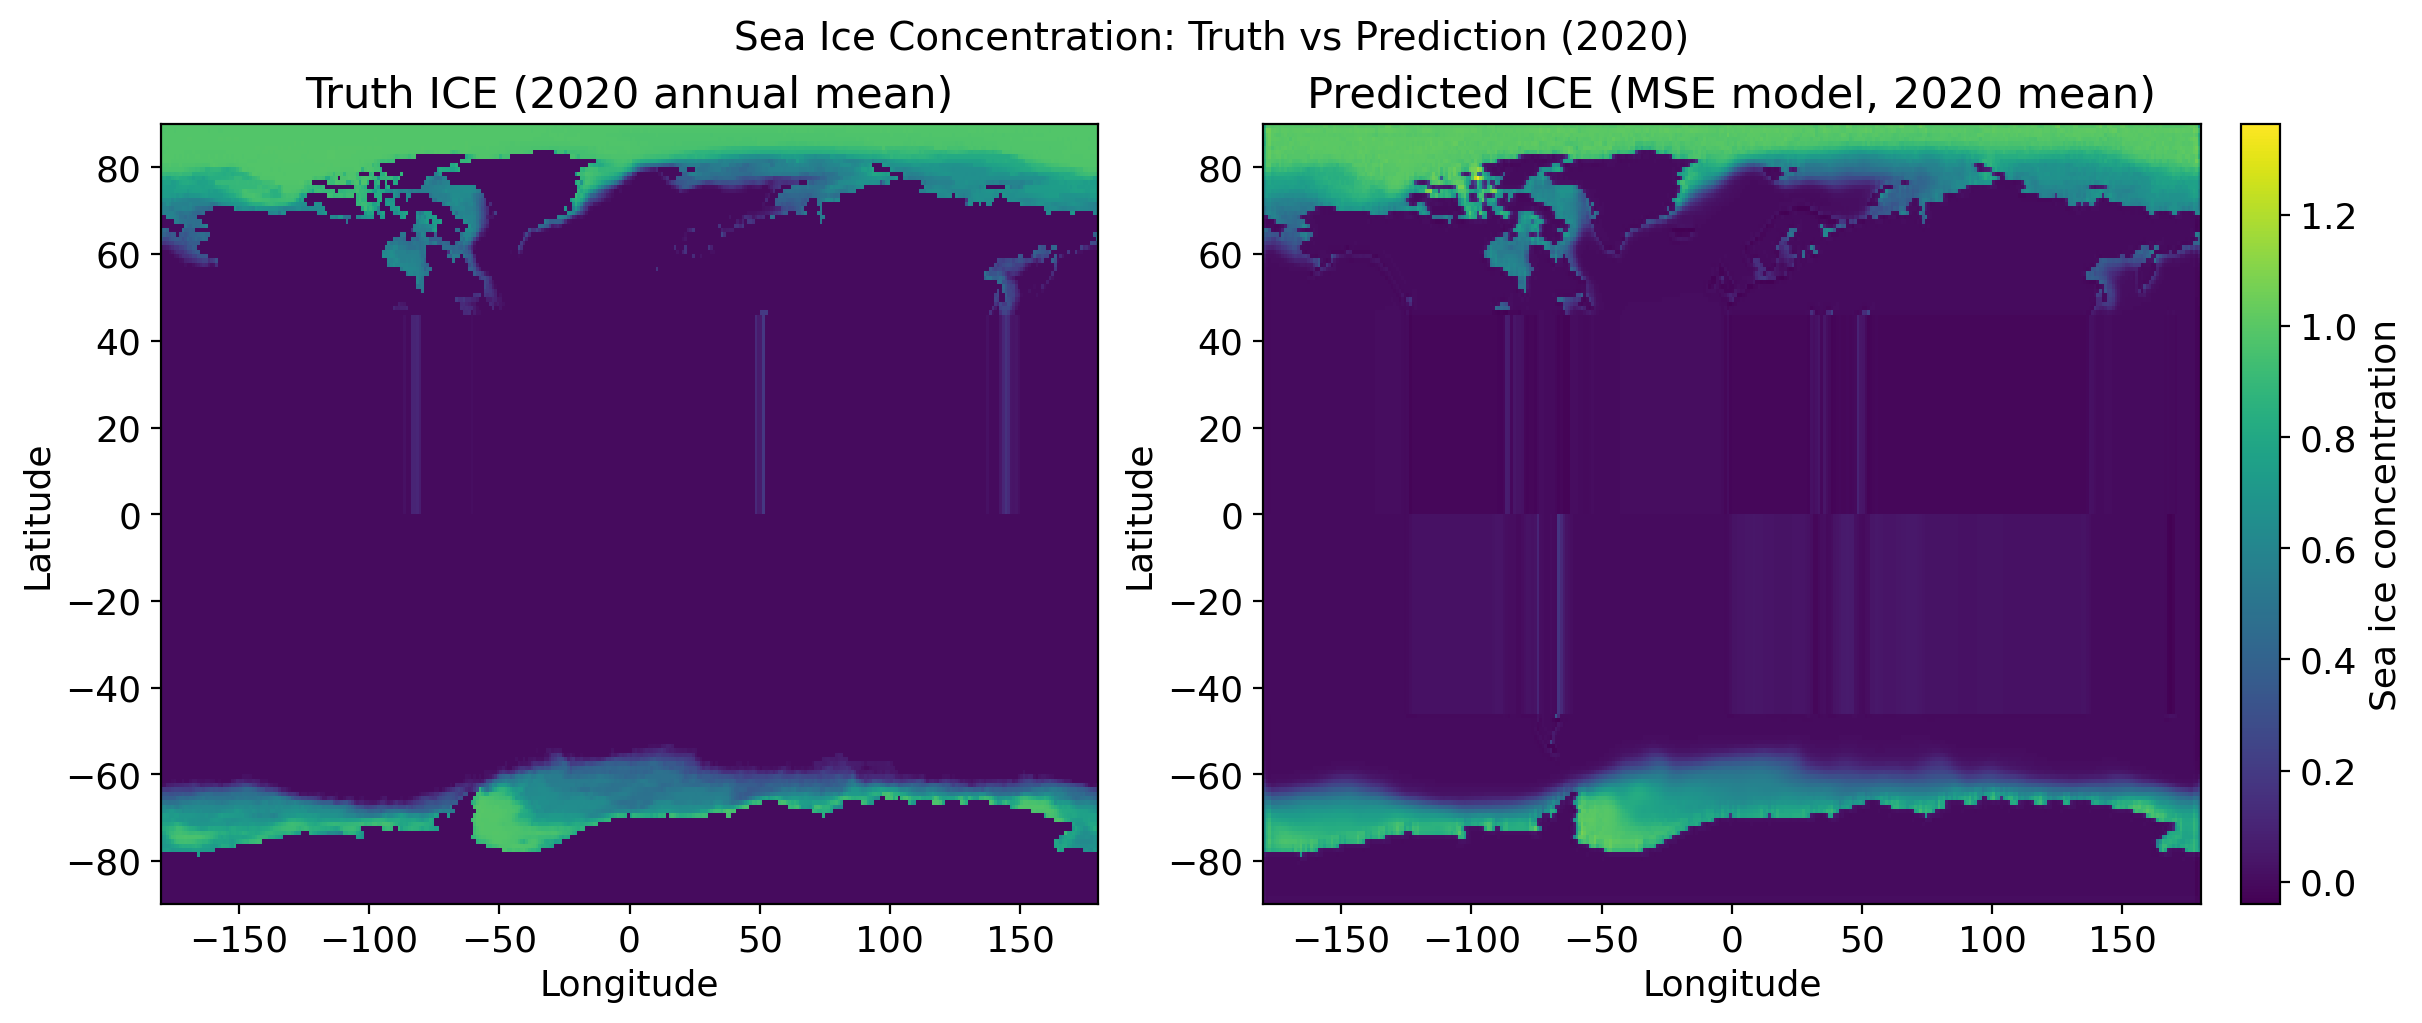

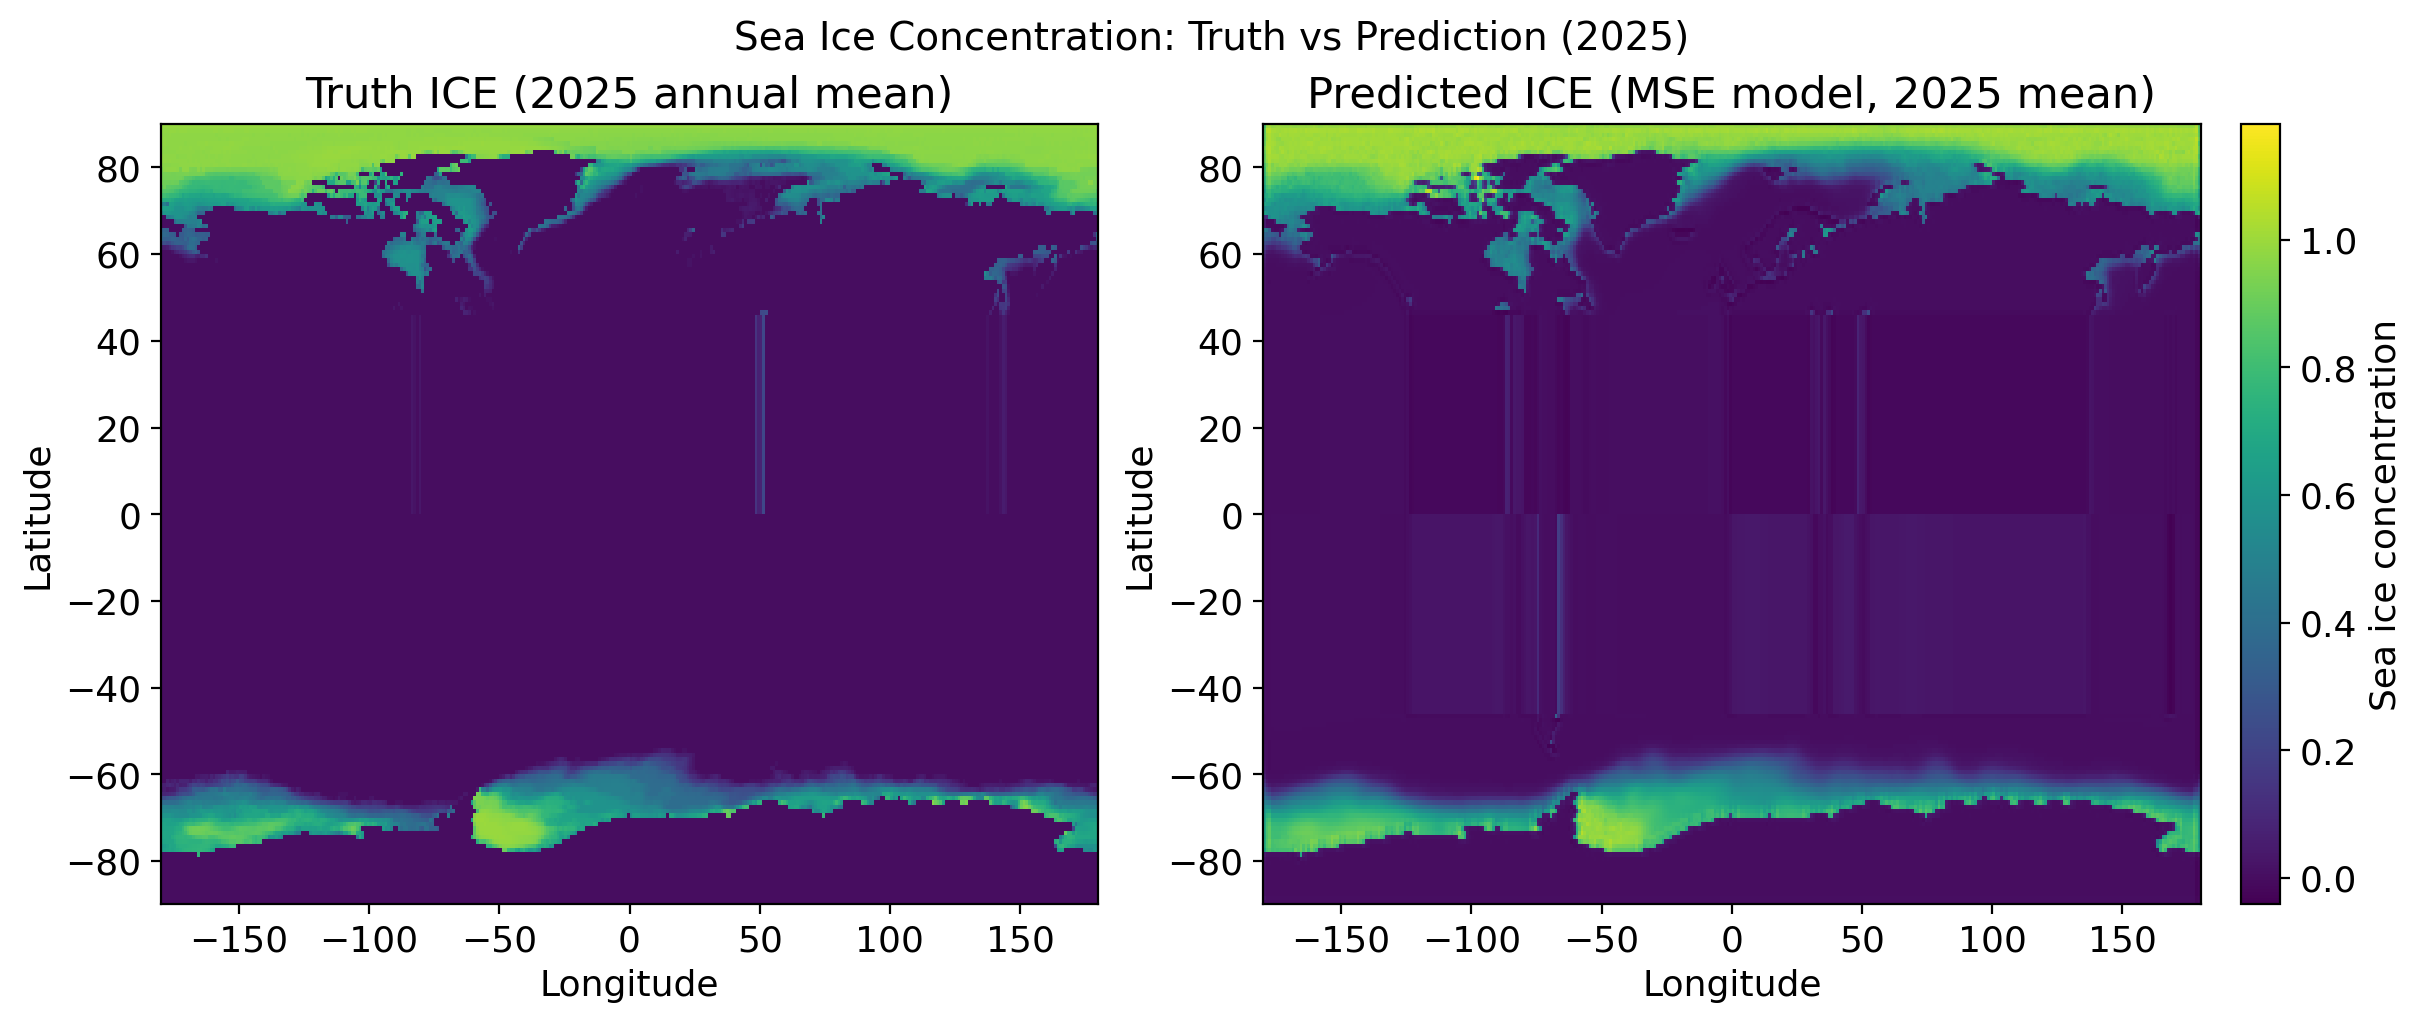

In [25]:
for year in [2015, 2020, 2025]:
    plot_year_maps(
        year=year,
        model=model_mse,
        X_data=X_test,
        y_data=y_test,
        ds_data=ds_test,
        lat=lat,
        lon=lon,
        device=device,
    )


In [73]:
from copy import deepcopy

def compute_march_predictions(year, model, X_data, y_data, ds_data, device):

    times = ds_data.time
    mask = (times.dt.year == year) & (times.dt.month == 3)
    idx = np.where(mask.values)[0]

    if len(idx) == 0:
        print(f"No March data found for year {year} in ds_test.")
        return None, None

    X_sel = X_data[idx]
    y_sel = y_data[idx]

    model = model.to(device)
    model.eval()
    with torch.no_grad():
        inputs = torch.from_numpy(X_sel).float().to(device)
        outputs = model(inputs).cpu().numpy()

    pred_mean  = outputs.mean(axis=0).squeeze()
    truth_mean = y_sel.mean(axis=0).squeeze()

    return pred_mean, truth_mean

In [76]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

ice_cmap = LinearSegmentedColormap.from_list("ice_white_navy", ["white", "navy"])

def plot_march_maps_polar(year, model, X_data, y_data, ds_data, lat, lon, device):

    pred_mean, truth_mean = compute_march_predictions(
        year, model, X_data, y_data, ds_data, device
    )
    if pred_mean is None:
        return

    lon2d, lat2d = np.meshgrid(lon, lat)

    lat_mask = (lat2d >= 45) | (lat2d <= -45)

    truth_plot = deepcopy(truth_mean)
    pred_plot  = deepcopy(pred_mean)

    truth_plot[~lat_mask] = np.nan
    pred_plot[~lat_mask]  = np.nan

    vmin, vmax = 0.0, 1

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    # Truth
    im0 = axes[0].pcolormesh(
        lon2d, lat2d, truth_plot,
        shading='auto', vmin=vmin, vmax=vmax, cmap=ice_cmap
    )
    axes[0].set_title(f"Truth ICE (March {year})")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    # Prediction
    im1 = axes[1].pcolormesh(
        lon2d, lat2d, pred_plot,
        shading='auto', vmin=vmin, vmax=vmax, cmap=ice_cmap
    )
    axes[1].set_title(f"Predicted ICE (MSE model, March {year})")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    cbar = fig.colorbar(im1, ax=axes[:], fraction=0.02, pad=0.02)
    cbar.set_label("Sea ice concentration")

    plt.suptitle(f"Sea Ice Concentration: Truth vs Prediction (March {year})")
    plt.show()


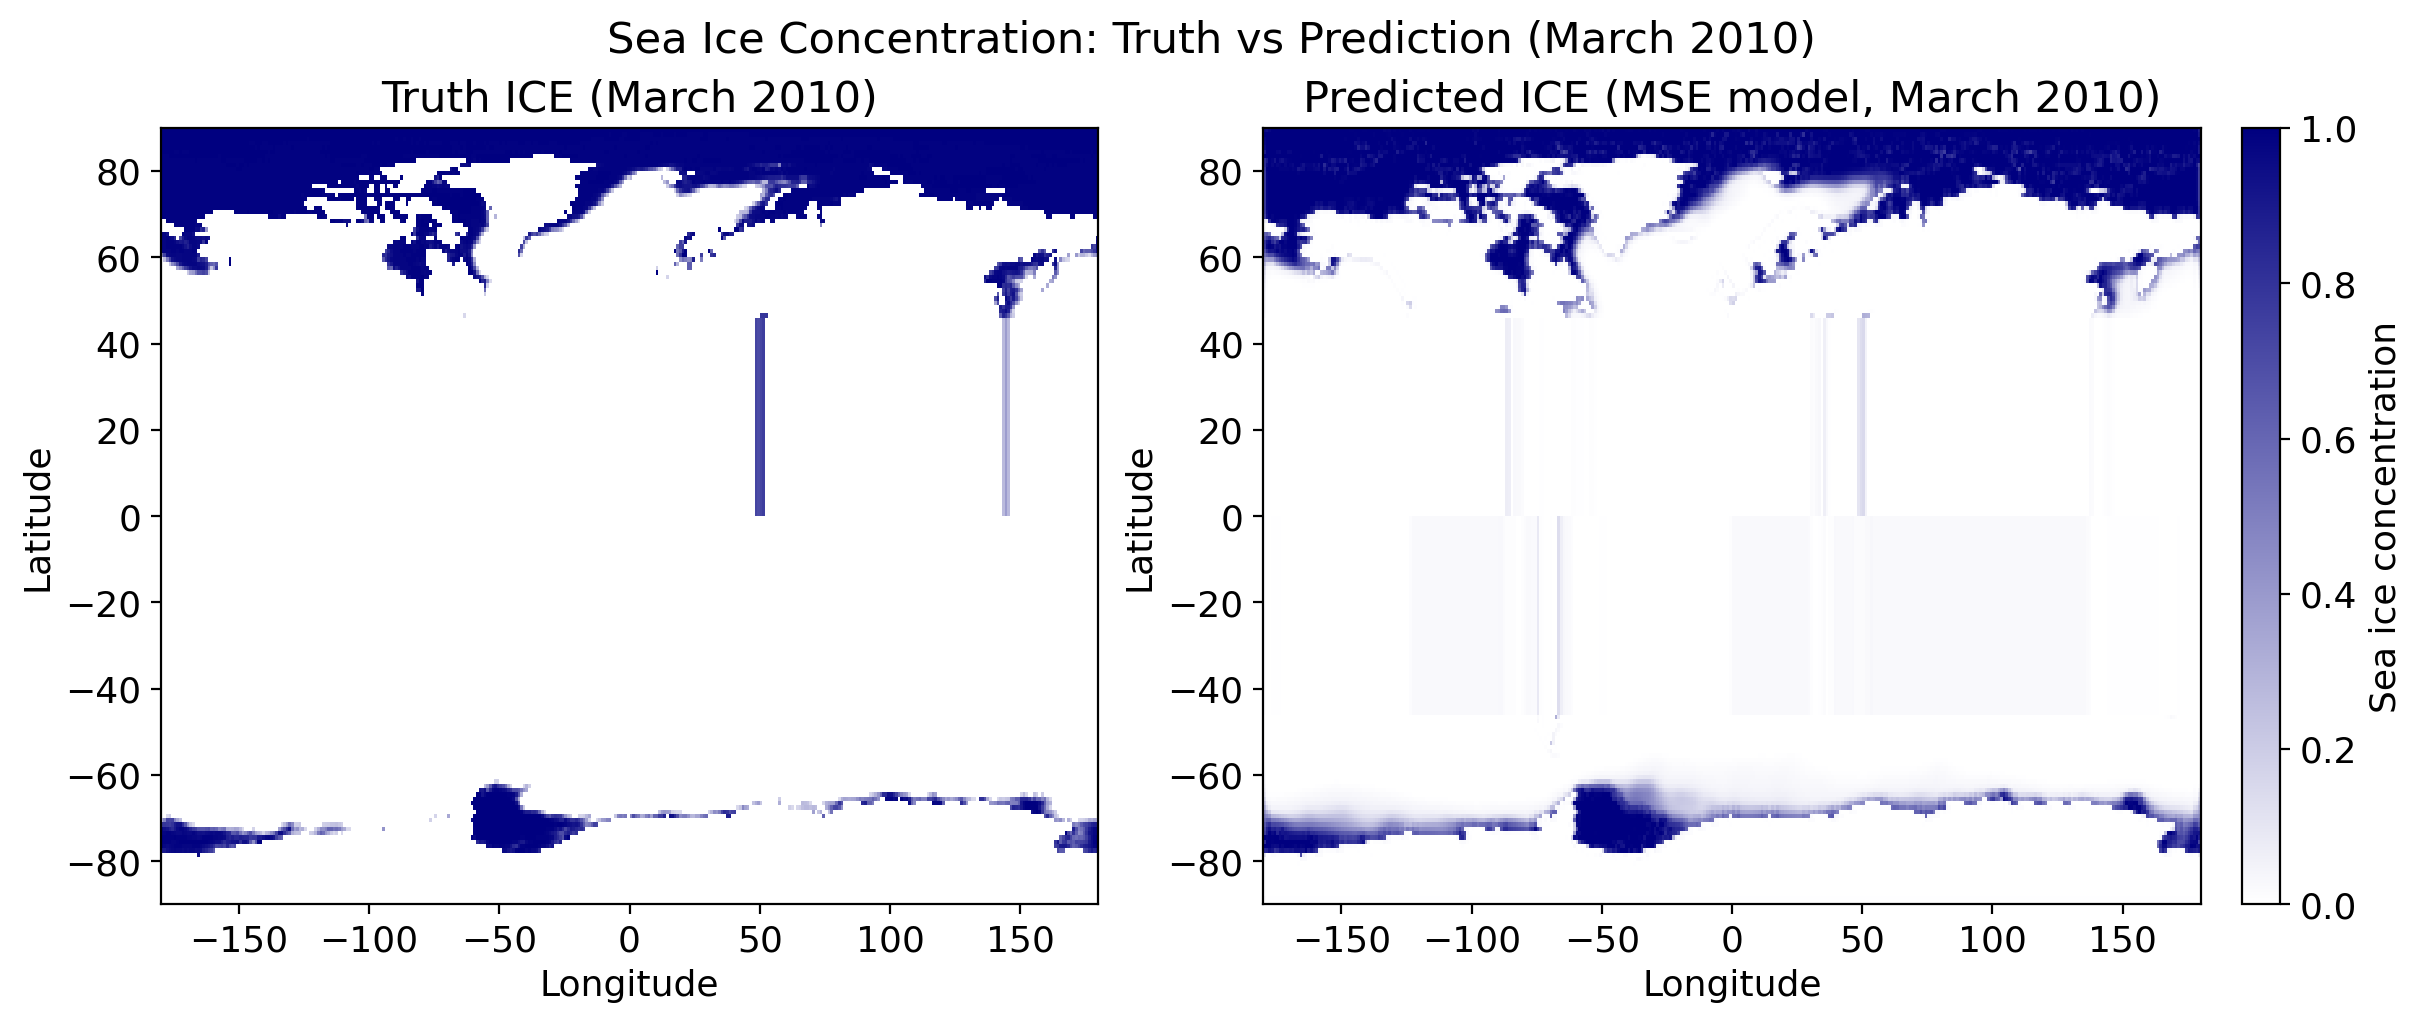

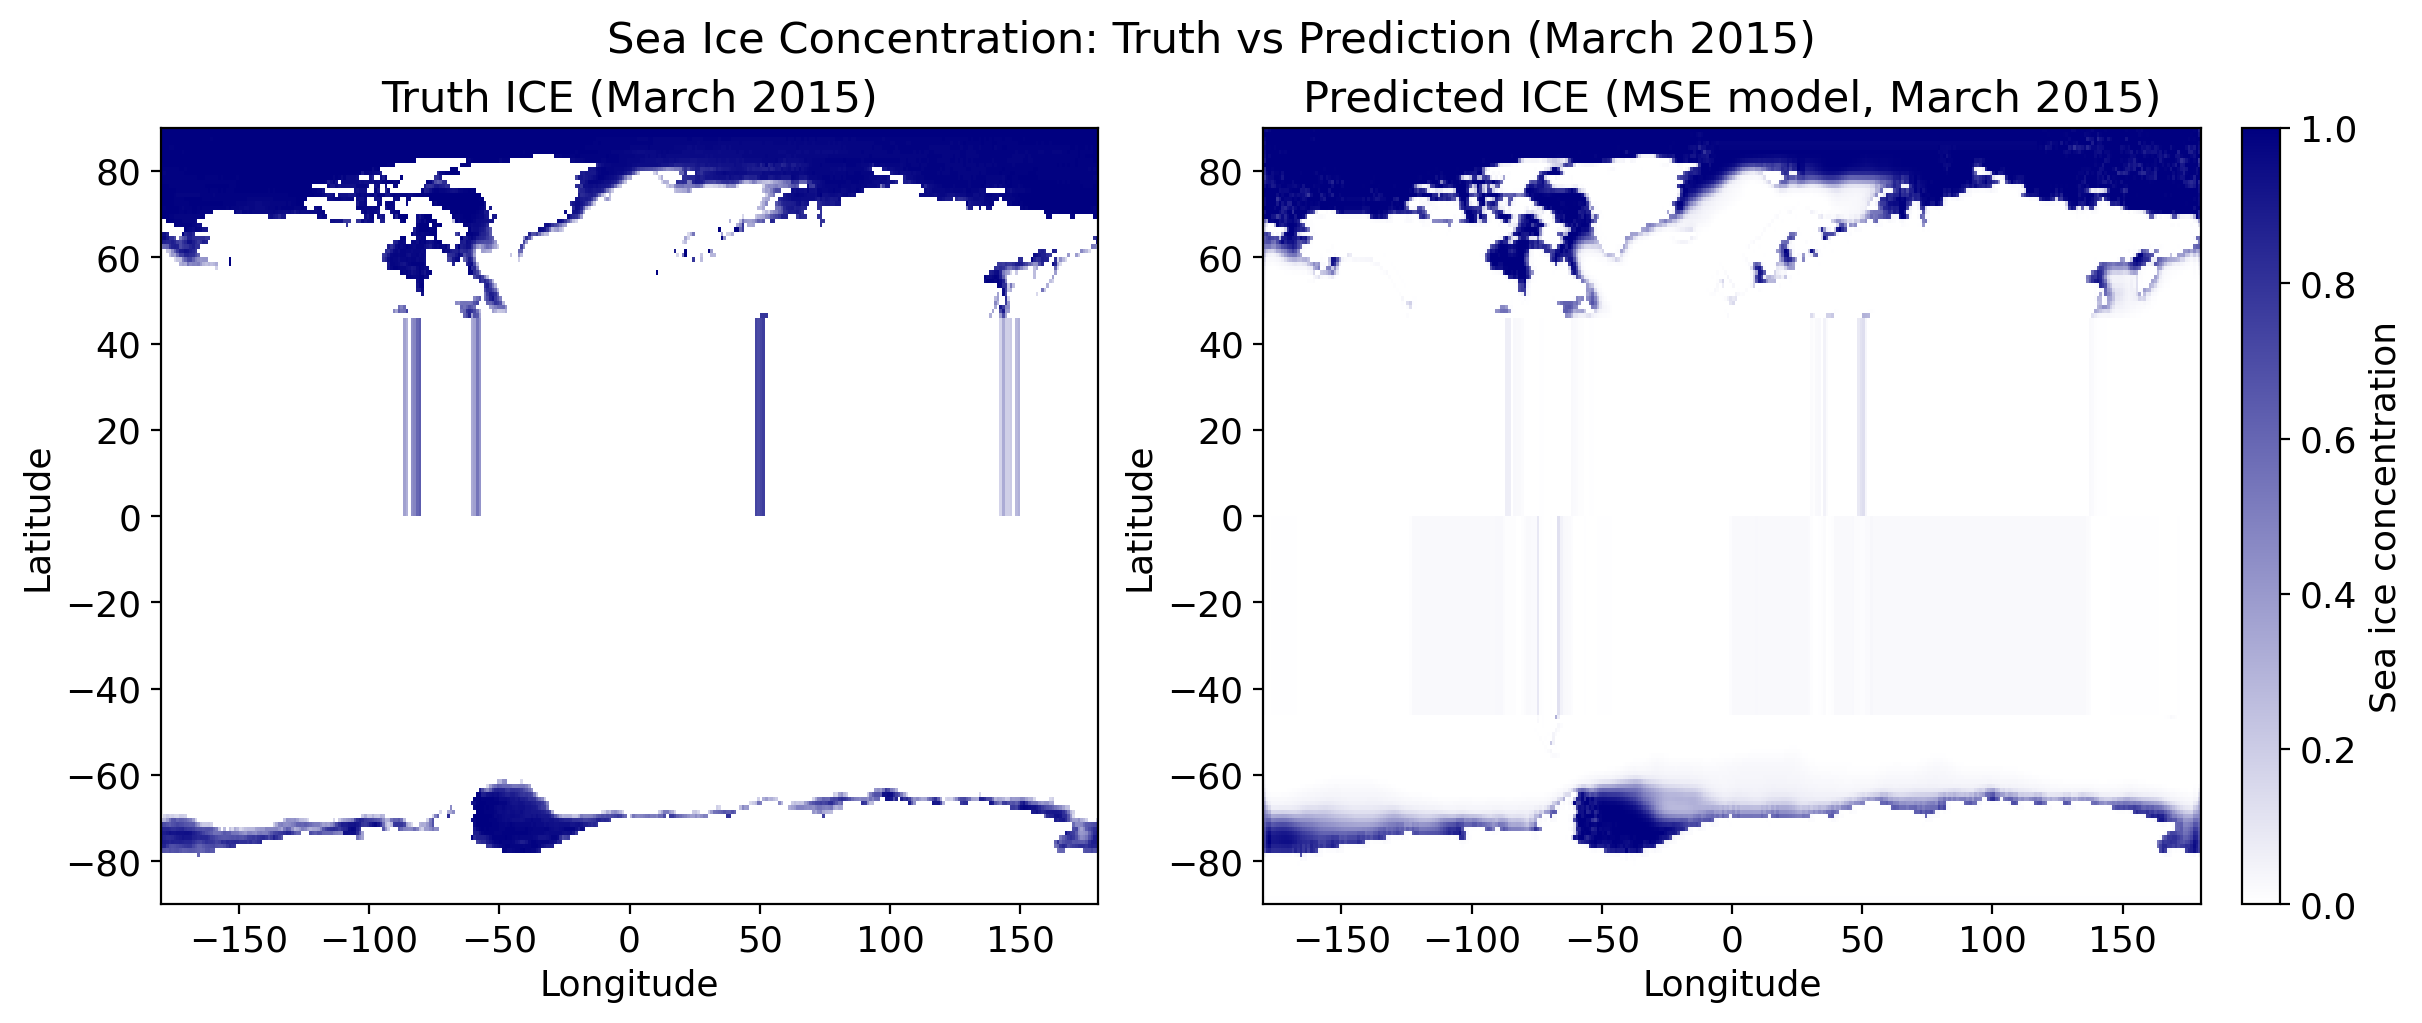

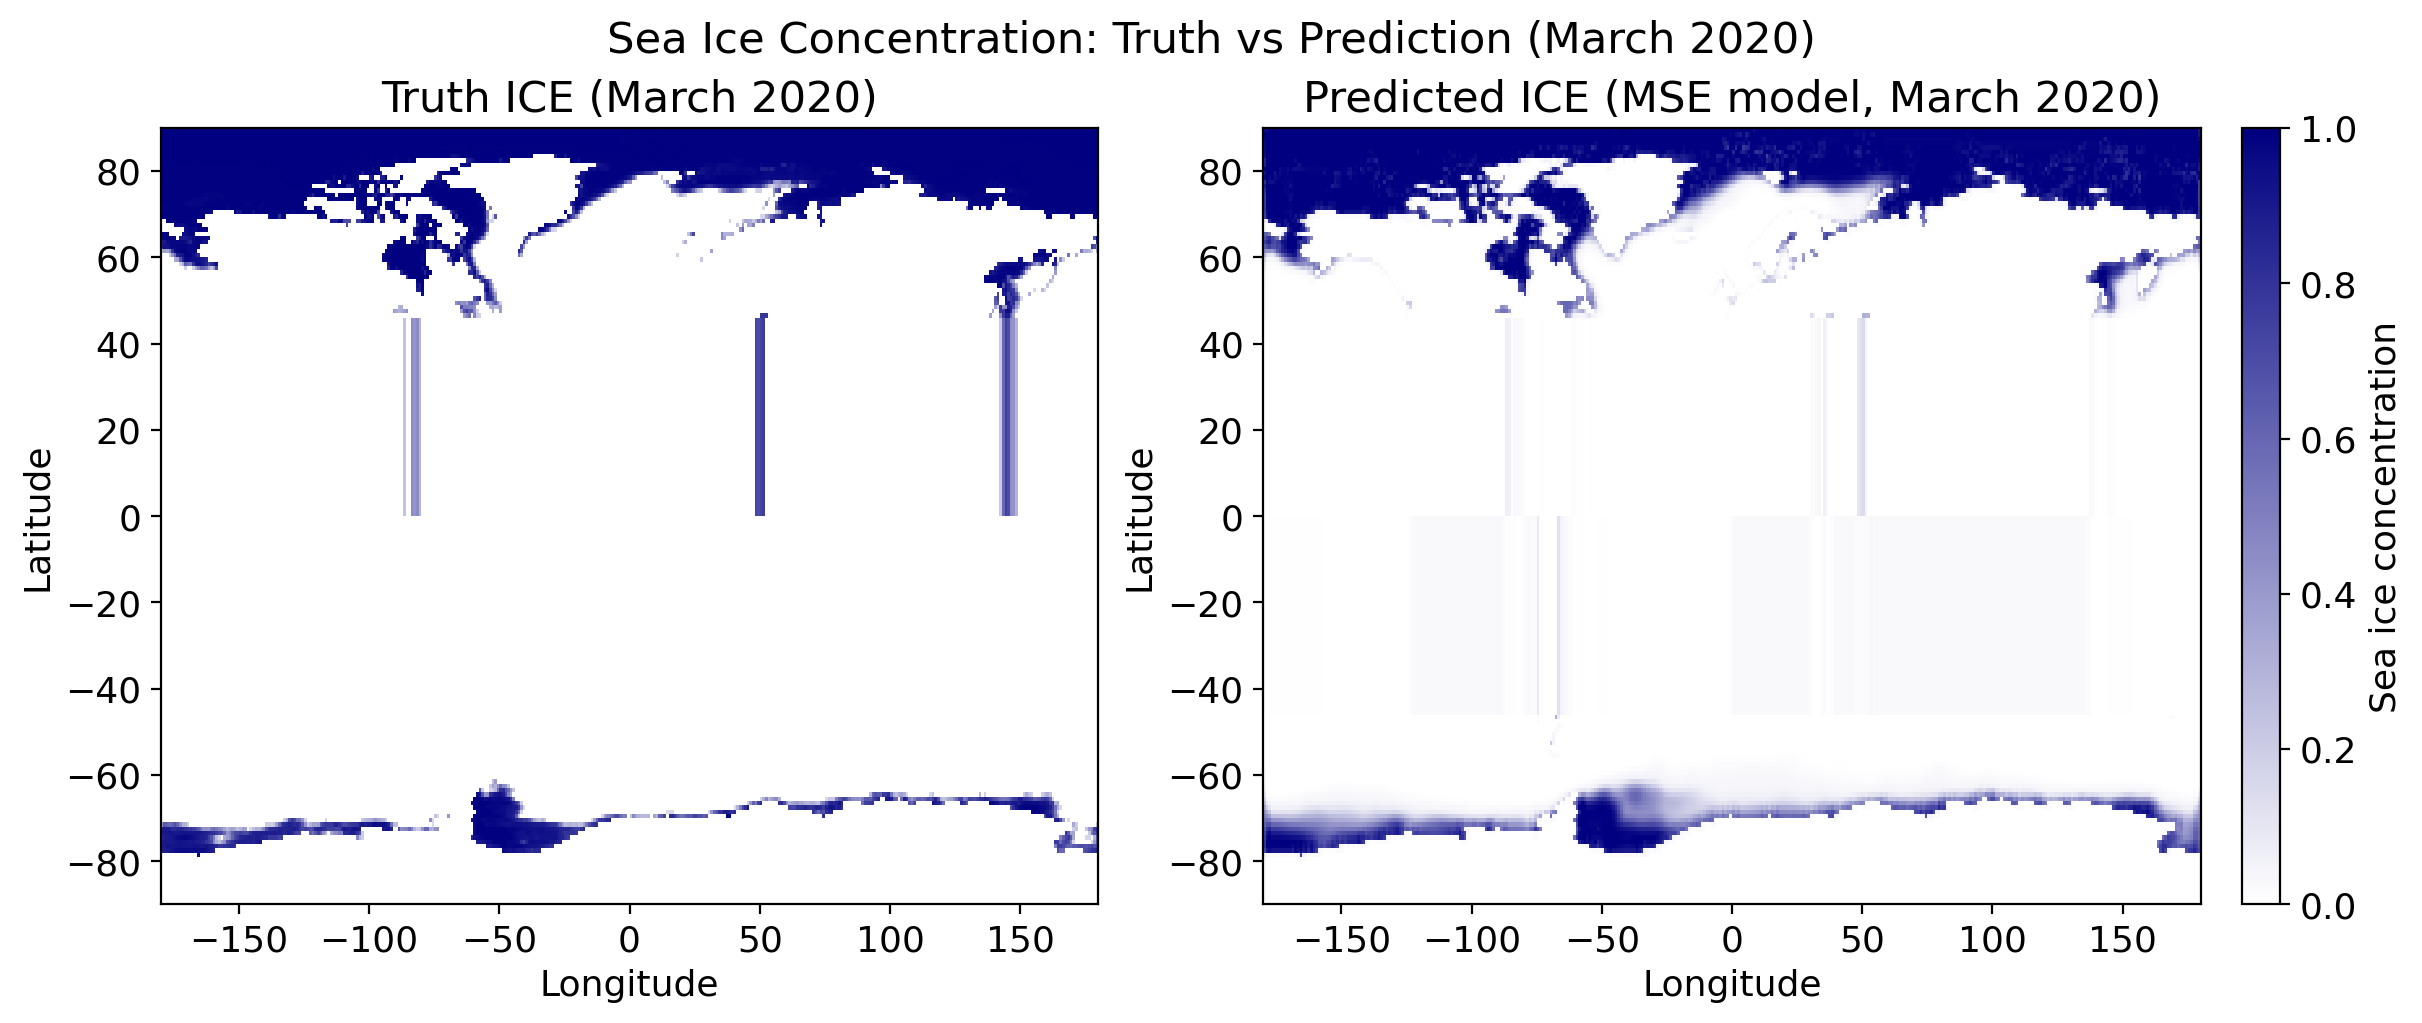

In [77]:
for year in [2010, 2015, 2020]:
    plot_march_maps_polar(
        year=year,
        model=model_mse,
        X_data=X_test,
        y_data=y_test,
        ds_data=ds_test,
        lat=lat,
        lon=lon,
        device=device,
    )


In [63]:
def plot_march_maps_greenland_cartopy(year, model, X_data, y_data, ds_data, lat, lon, device):
    pred_mean, truth_mean = compute_march_predictions(
        year, model, X_data, y_data, ds_data, device
    )
    if pred_mean is None:
        return

    lon_fixed = np.where(lon > 180, lon - 360, lon)
    lon2d, lat2d = np.meshgrid(lon_fixed, lat)

    # Greenland
    lon_min, lon_max = -55, -20
    lat_min, lat_max = 60, 85

    mask = (
        (lat2d >= lat_min) & (lat2d <= lat_max) &
        (lon2d >= lon_min) & (lon2d <= lon_max)
    )

    truth_plot = truth_mean.copy()
    pred_plot  = pred_mean.copy()
    truth_plot[~mask] = np.nan
    pred_plot[~mask]  = np.nan

    vmin, vmax = 0, 1
    proj = ccrs.PlateCarree()

    fig, axes = plt.subplots(
        1, 2, figsize=(12, 6),
        subplot_kw={"projection": proj},
        constrained_layout=True
    )

    # Truth
    im0 = axes[0].pcolormesh(
        lon2d, lat2d, truth_plot,
        transform=proj, cmap=ice_cmap, vmin=vmin, vmax=vmax
    )
    axes[0].add_feature(cfeature.LAND, facecolor='lightgray')
    axes[0].add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.7)
    axes[0].set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
    axes[0].set_title(f"Truth ICE – March {year}, Greenland")

    # Prediction
    im1 = axes[1].pcolormesh(
        lon2d, lat2d, pred_plot,
        transform=proj, cmap=ice_cmap, vmin=vmin, vmax=vmax
    )
    axes[1].add_feature(cfeature.LAND, facecolor='lightgray')
    axes[1].add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.7)
    axes[1].set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
    axes[1].set_title(f"Predicted ICE – March {year}, Greenland")

    cbar = fig.colorbar(im1, ax=axes.ravel().tolist(), fraction=0.03, pad=0.02)
    cbar.set_label("Sea ice concentration")

    plt.suptitle(f"Sea Ice Concentration: Truth vs Prediction (March {year}, Greenland)", fontsize=15)
    plt.show()


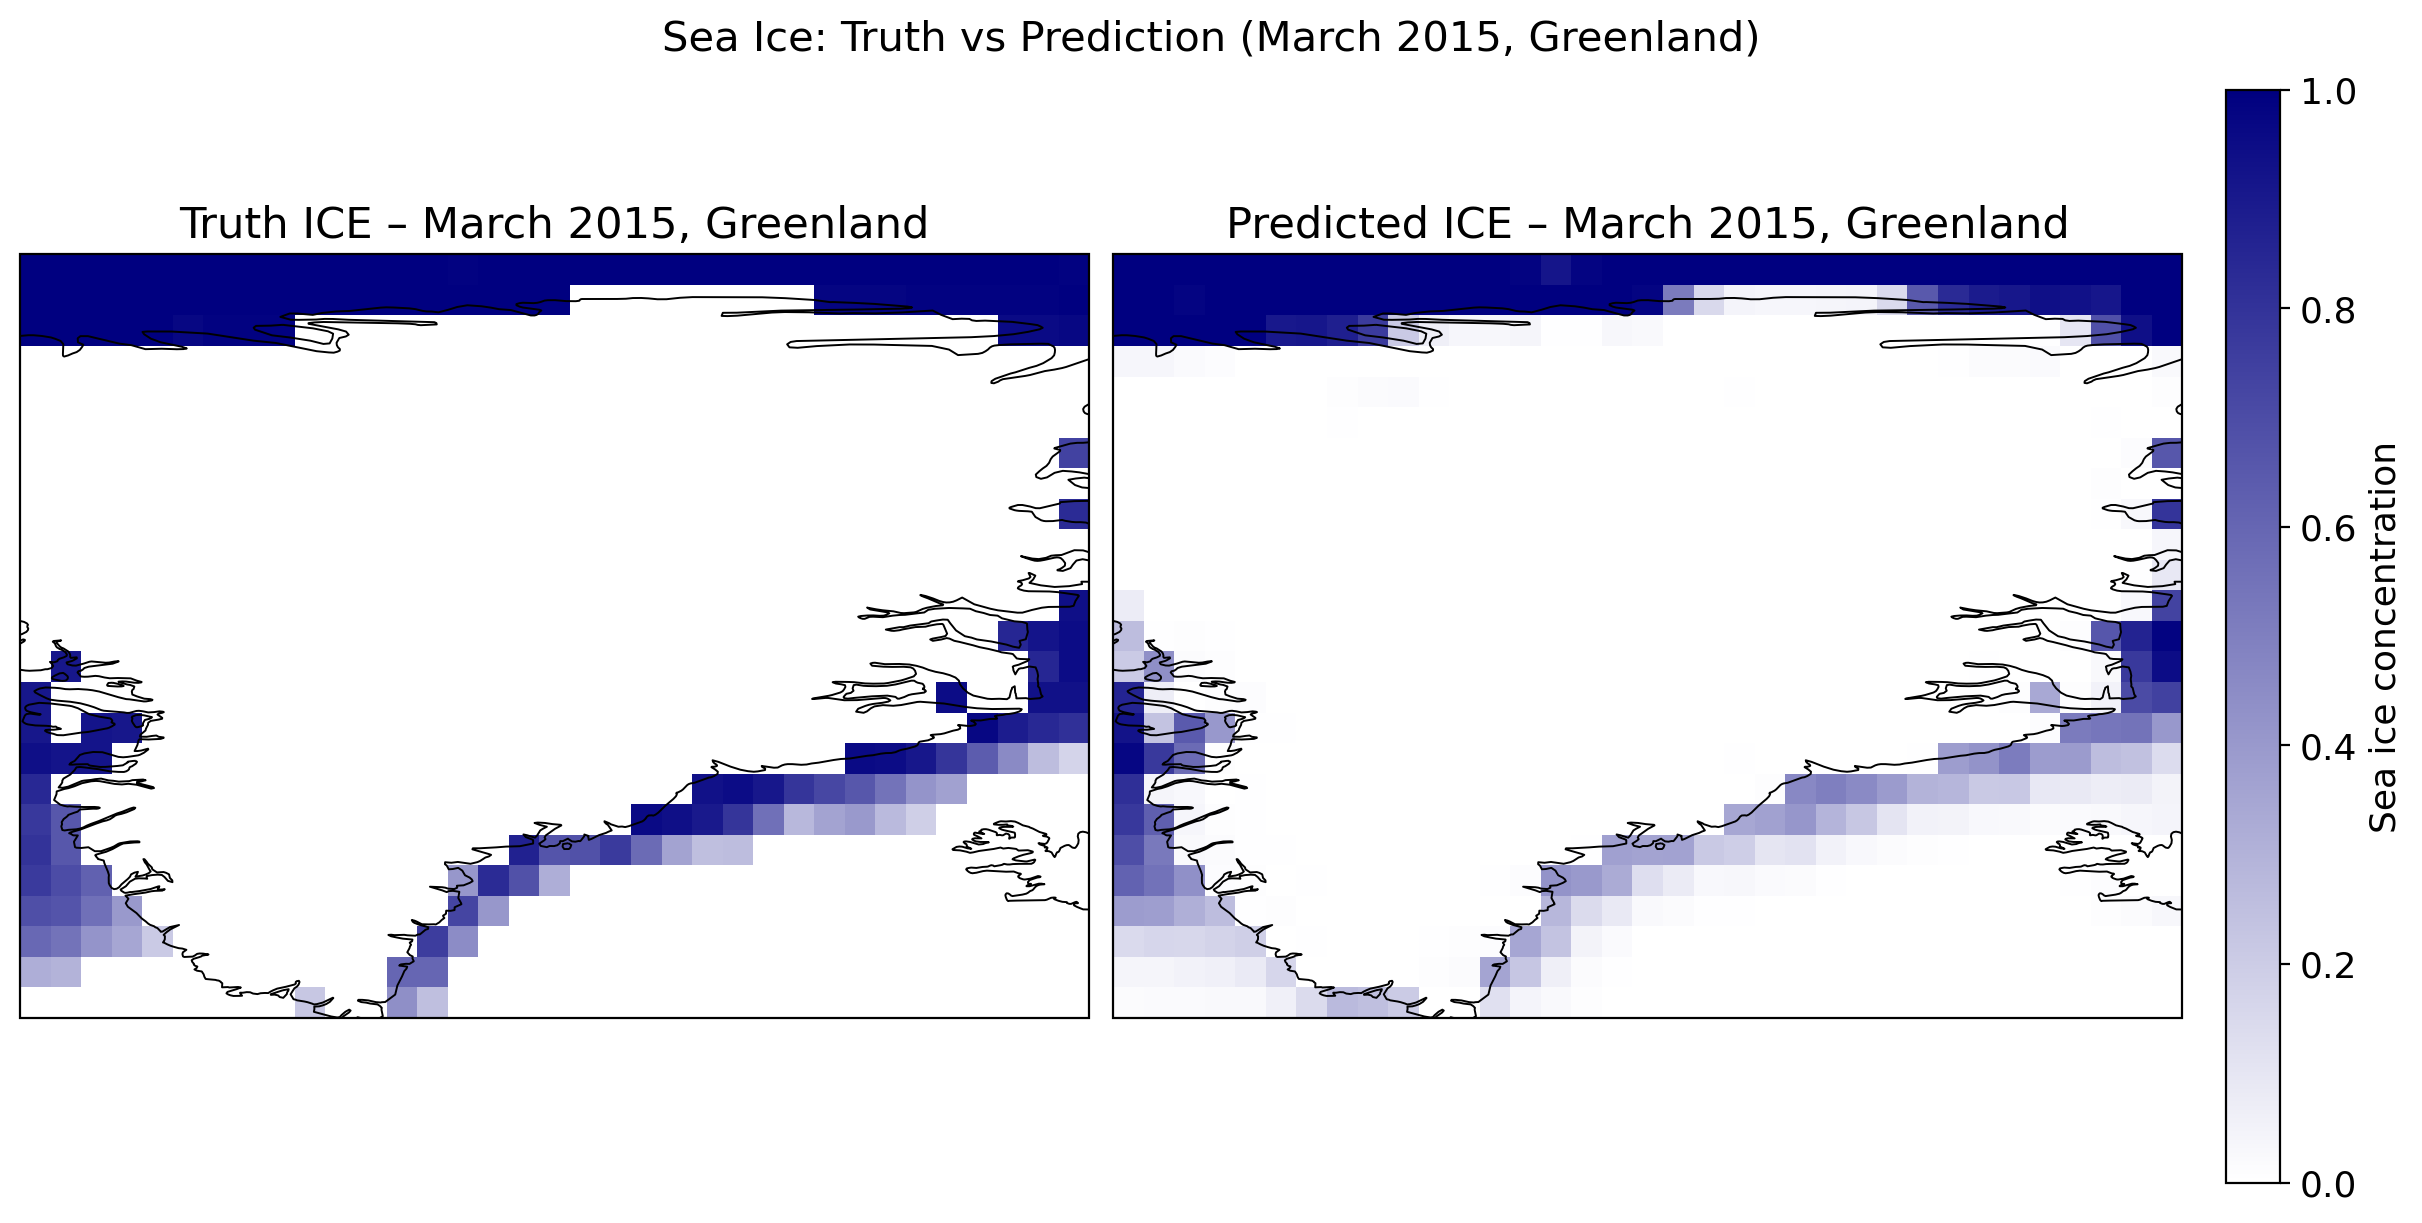

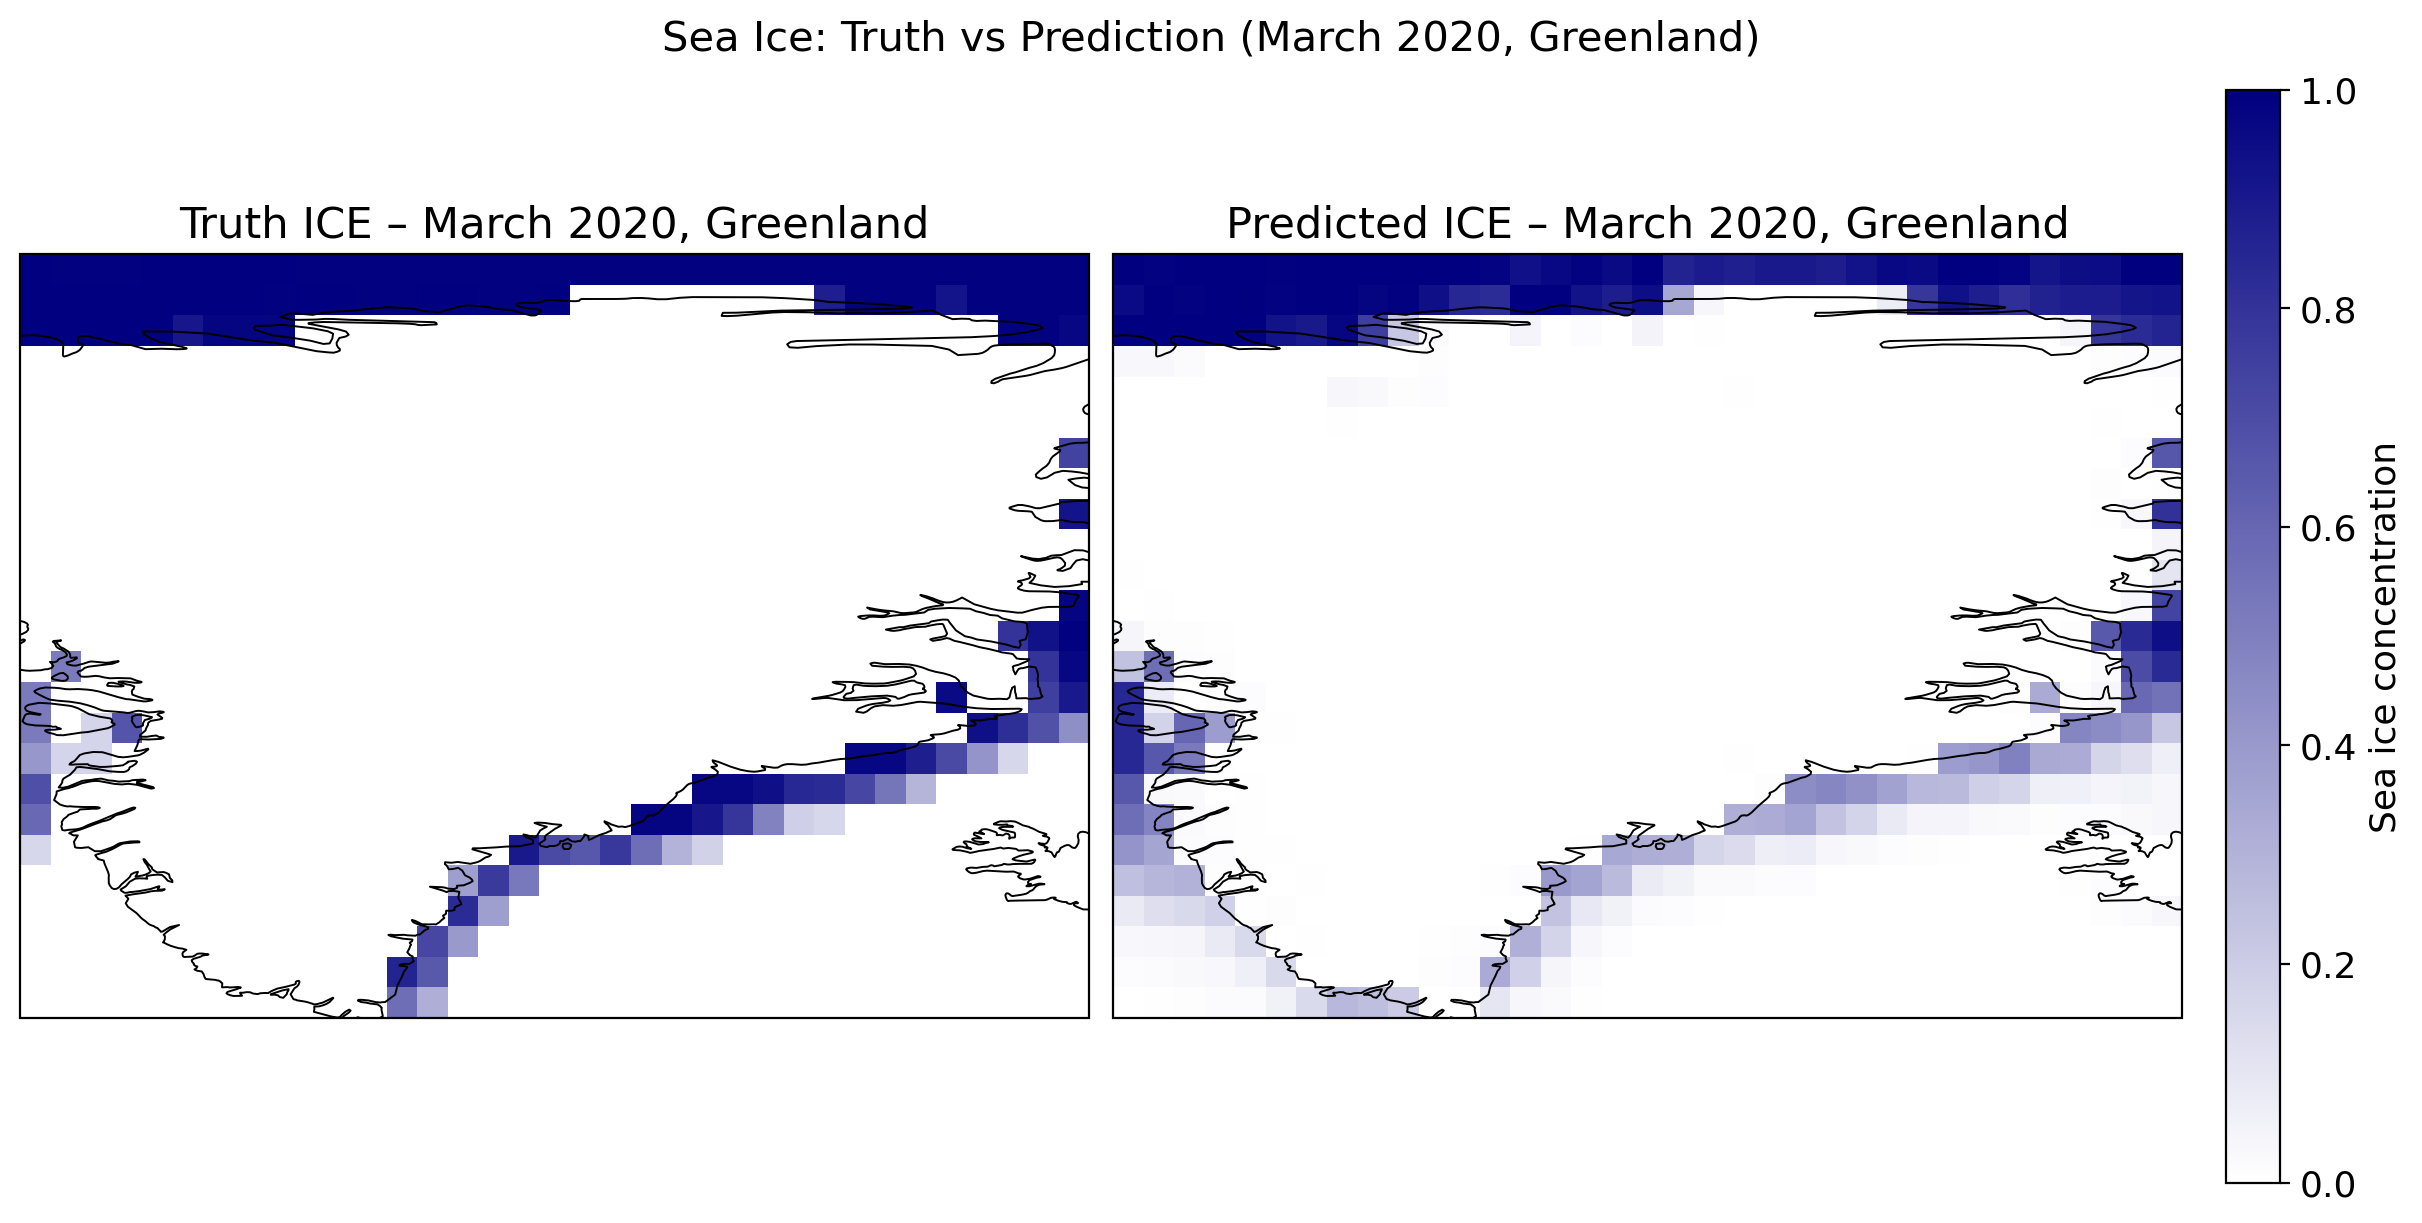

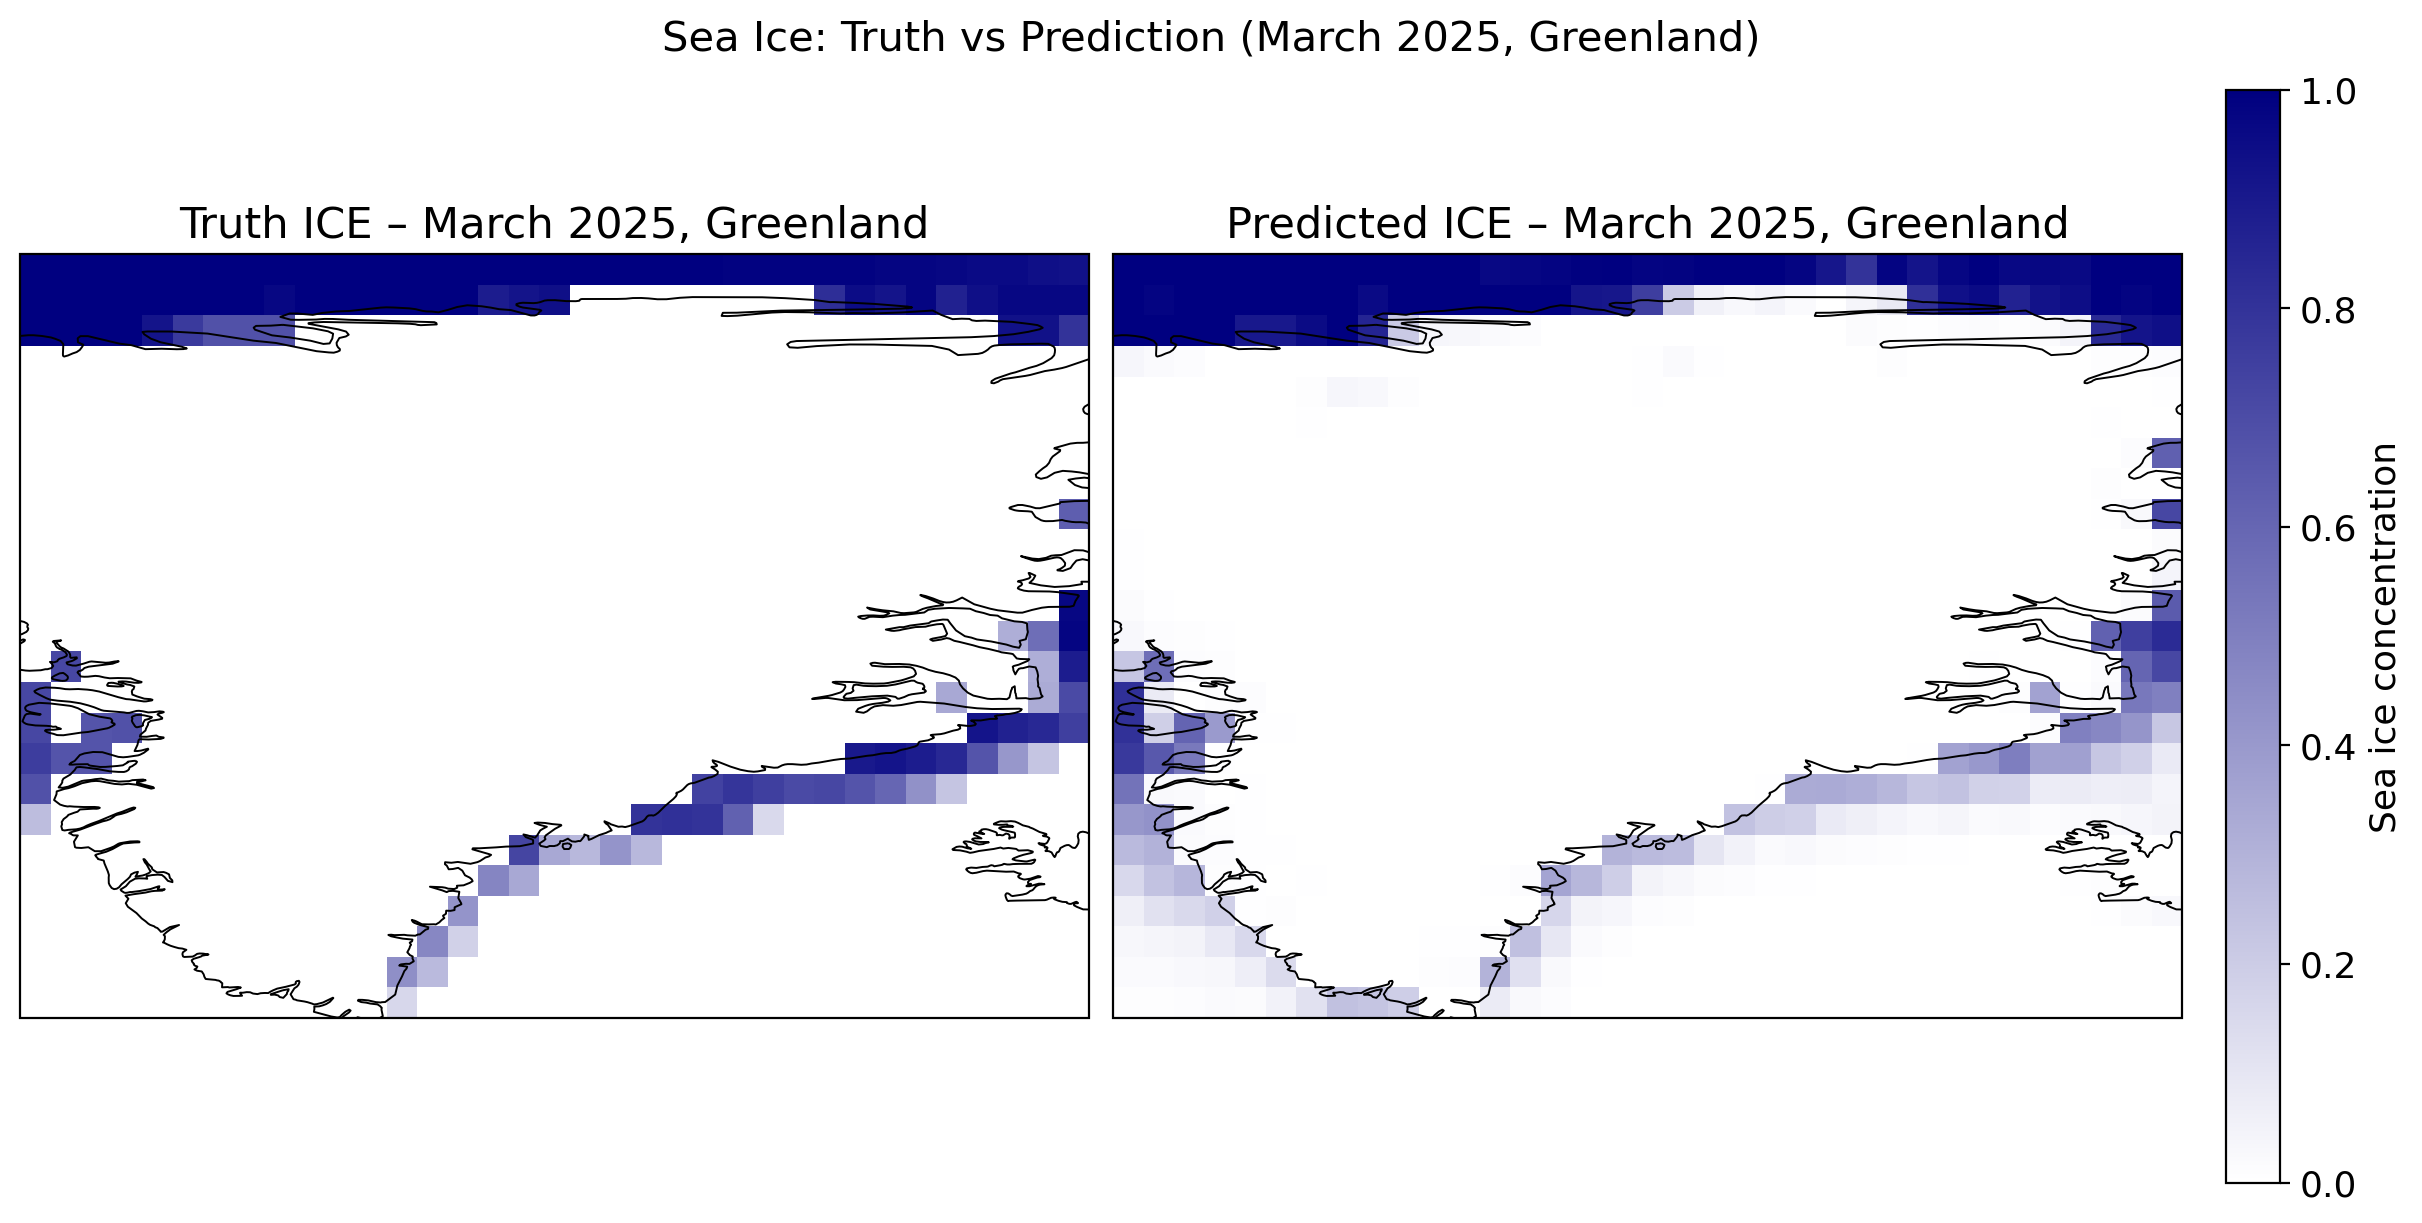

In [64]:
for year in [2015, 2020, 2025]:
    plot_march_maps_greenland_cartopy(
        year, model_mse, X_test, y_test, ds_test, lat, lon, device
    )

In [57]:
def plot_march_maps_polar_clean(year, model, X_data, y_data, ds_data, lat, lon, device):
    pred_mean, truth_mean = compute_march_predictions(
        year, model, X_data, y_data, ds_data, device
    )
    if pred_mean is None:
        return

    # Northern hemisphere
    north_mask = lat >= 45
    lat_north  = lat[north_mask]
    truth_n    = truth_mean[north_mask, :]
    pred_n     = pred_mean[north_mask, :]

    # Southern hemisphere
    south_mask = lat <= -45
    lat_south  = lat[south_mask]
    truth_s    = truth_mean[south_mask, :]
    pred_s     = pred_mean[south_mask, :]

    lon2d_n, lat2d_n = np.meshgrid(lon, lat_north)
    lon2d_s, lat2d_s = np.meshgrid(lon, lat_south)

    vmin, vmax = 0, 1

    fig, axs = plt.subplots(
        2, 2, figsize=(12, 10), sharex=True, constrained_layout=True
    )

    # Northern Hemisphere (Truth)
    axs[0, 0].pcolormesh(
        lon2d_n, lat2d_n, truth_n,
        shading='auto', cmap=ice_cmap, vmin=vmin, vmax=vmax
    )
    axs[0, 0].set_title(f"Truth ICE (North, March {year})")
    axs[0, 0].set_ylabel("Latitude")

    # Northern Hemisphere (Pred)
    im = axs[0, 1].pcolormesh(
        lon2d_n, lat2d_n, pred_n,
        shading='auto', cmap=ice_cmap, vmin=vmin, vmax=vmax
    )
    axs[0, 1].set_title(f"Predicted ICE (North, March {year})")

    # Southern Hemisphere (Truth)
    axs[1, 0].pcolormesh(
        lon2d_s, lat2d_s, truth_s,
        shading='auto', cmap=ice_cmap, vmin=vmin, vmax=vmax
    )
    axs[1, 0].set_title(f"Truth ICE (South, March {year})")
    axs[1, 0].set_ylabel("Latitude")
    axs[1, 0].set_xlabel("Longitude")

    # Southern Hemisphere (Pred)
    axs[1, 1].pcolormesh(
        lon2d_s, lat2d_s, pred_s,
        shading='auto', cmap=ice_cmap, vmin=vmin, vmax=vmax
    )
    axs[1, 1].set_title(f"Predicted ICE (South, March {year})")
    axs[1, 1].set_xlabel("Longitude")

    fig.colorbar(im, ax=axs[:, :], shrink=0.6, label="Sea ice concentration")

    plt.suptitle(f"Sea Ice Concentration: Truth vs Prediction (March {year})", fontsize=16)
    plt.show()


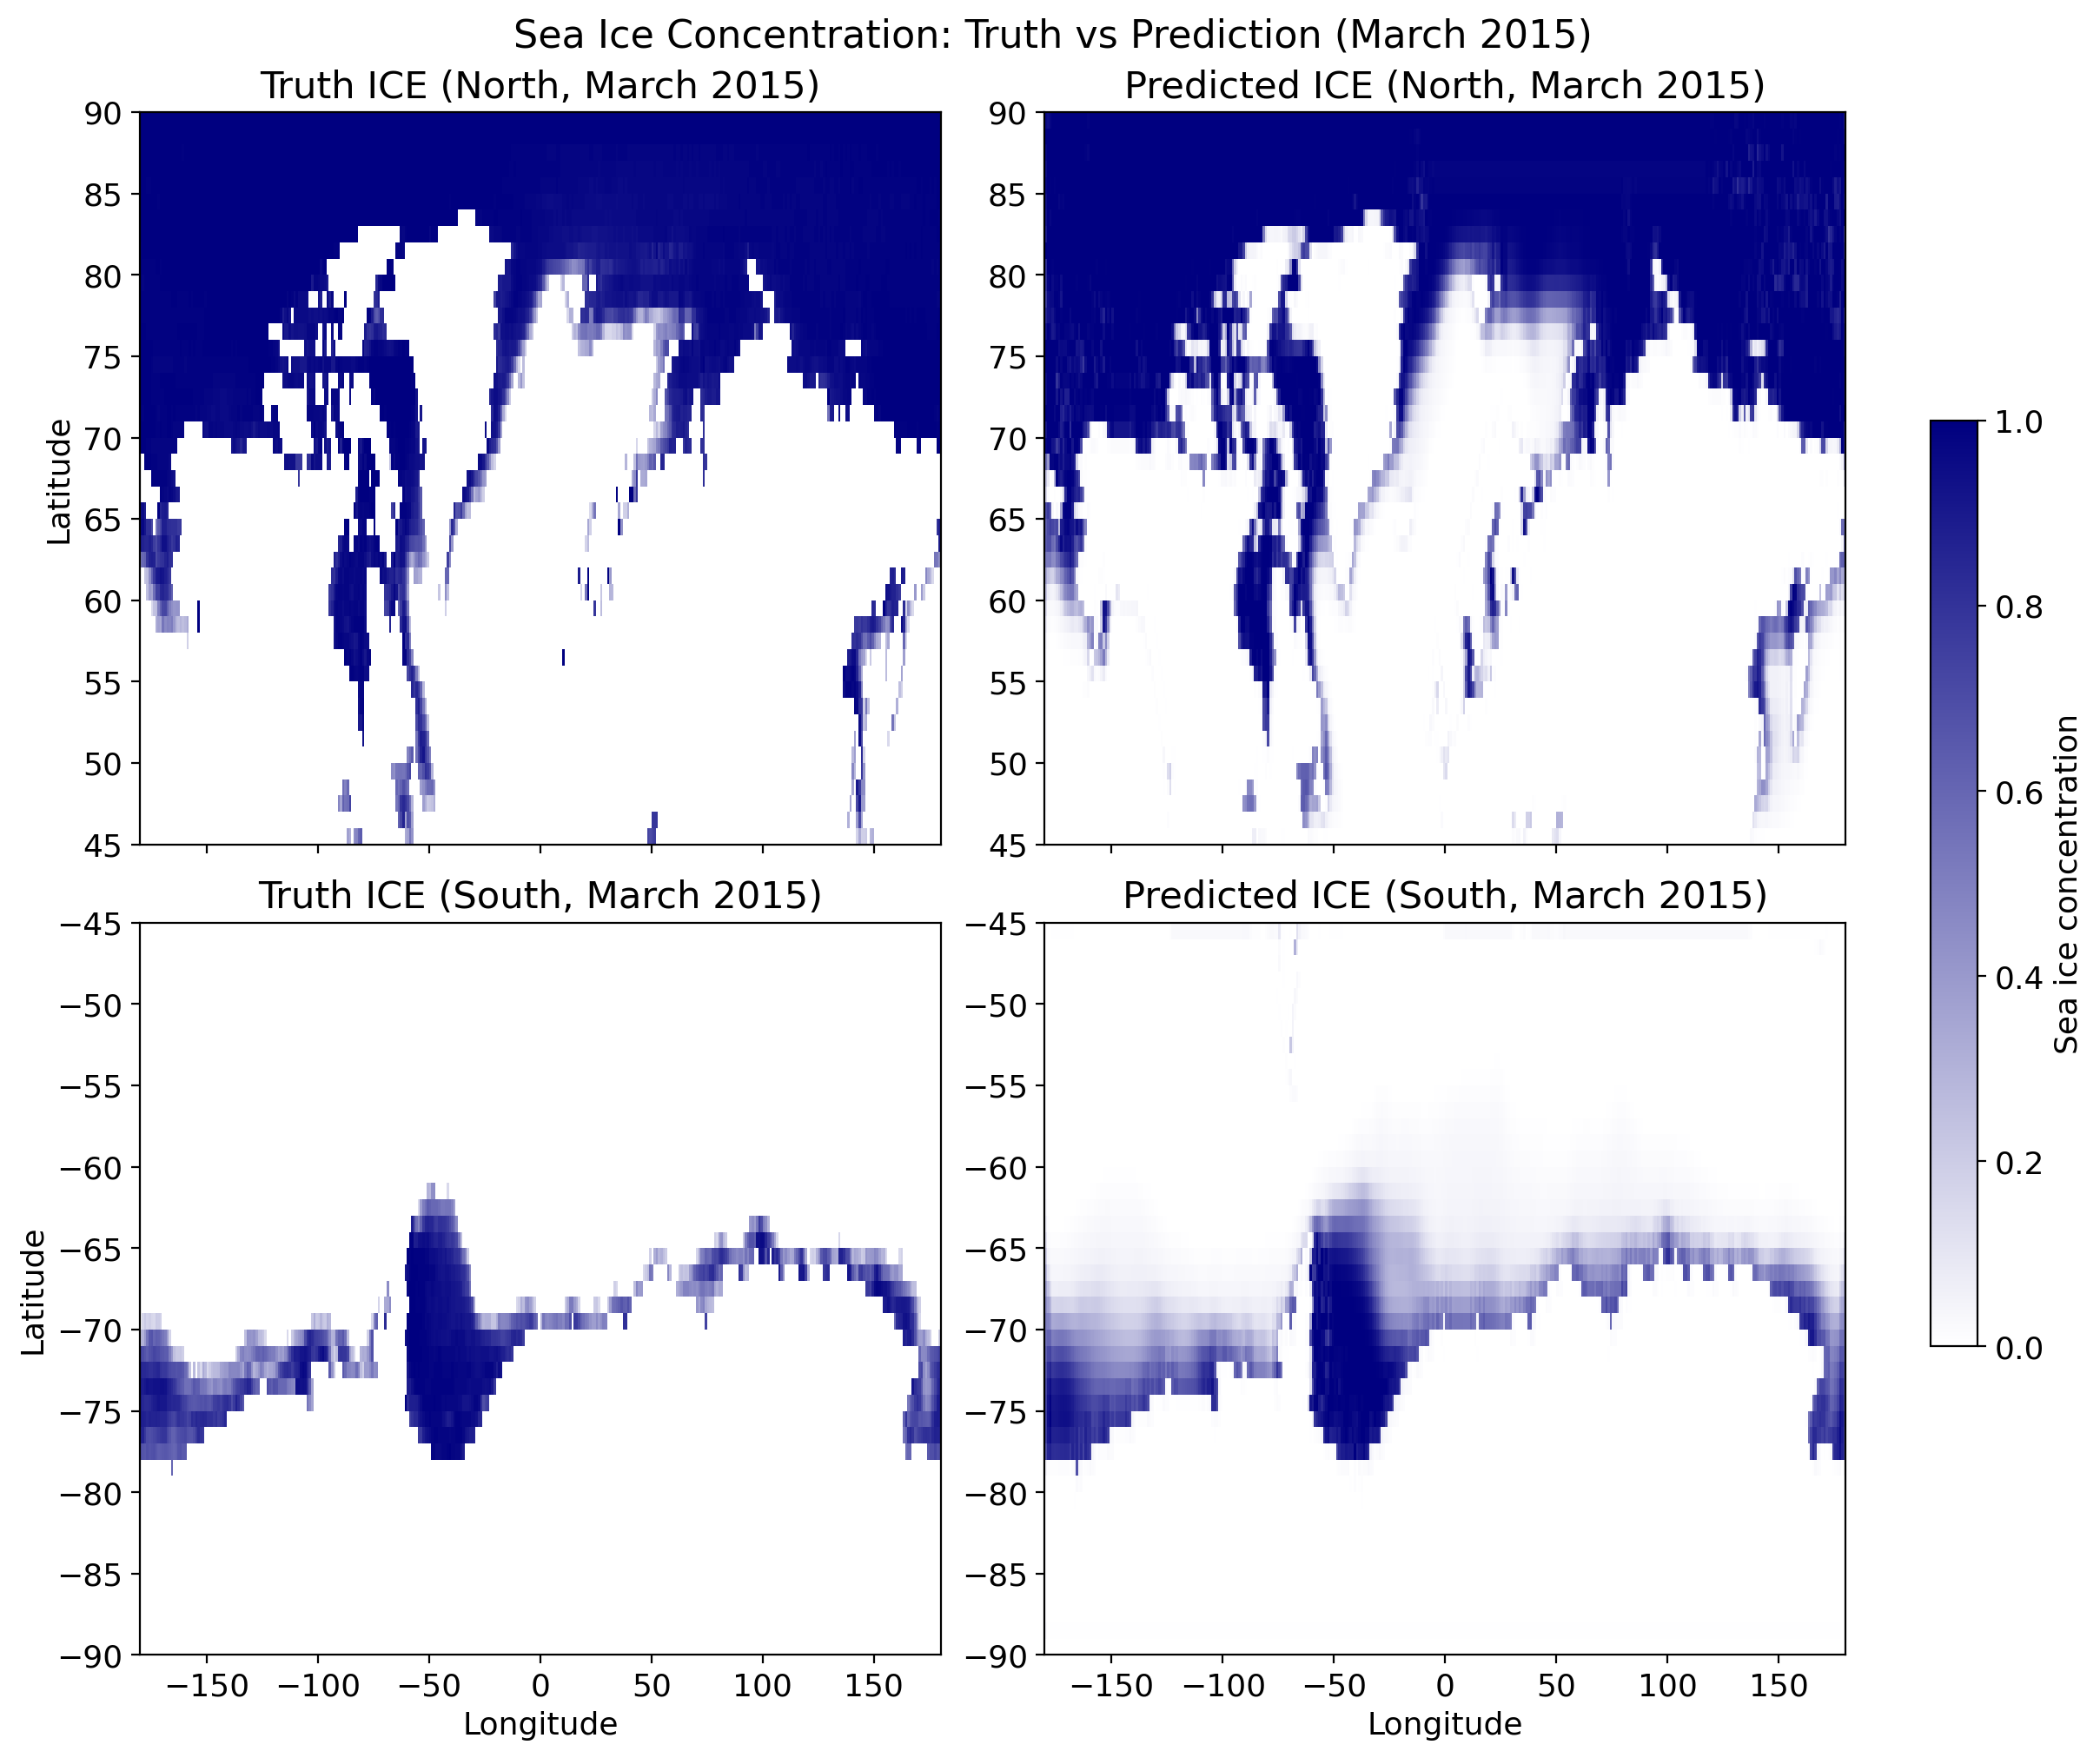

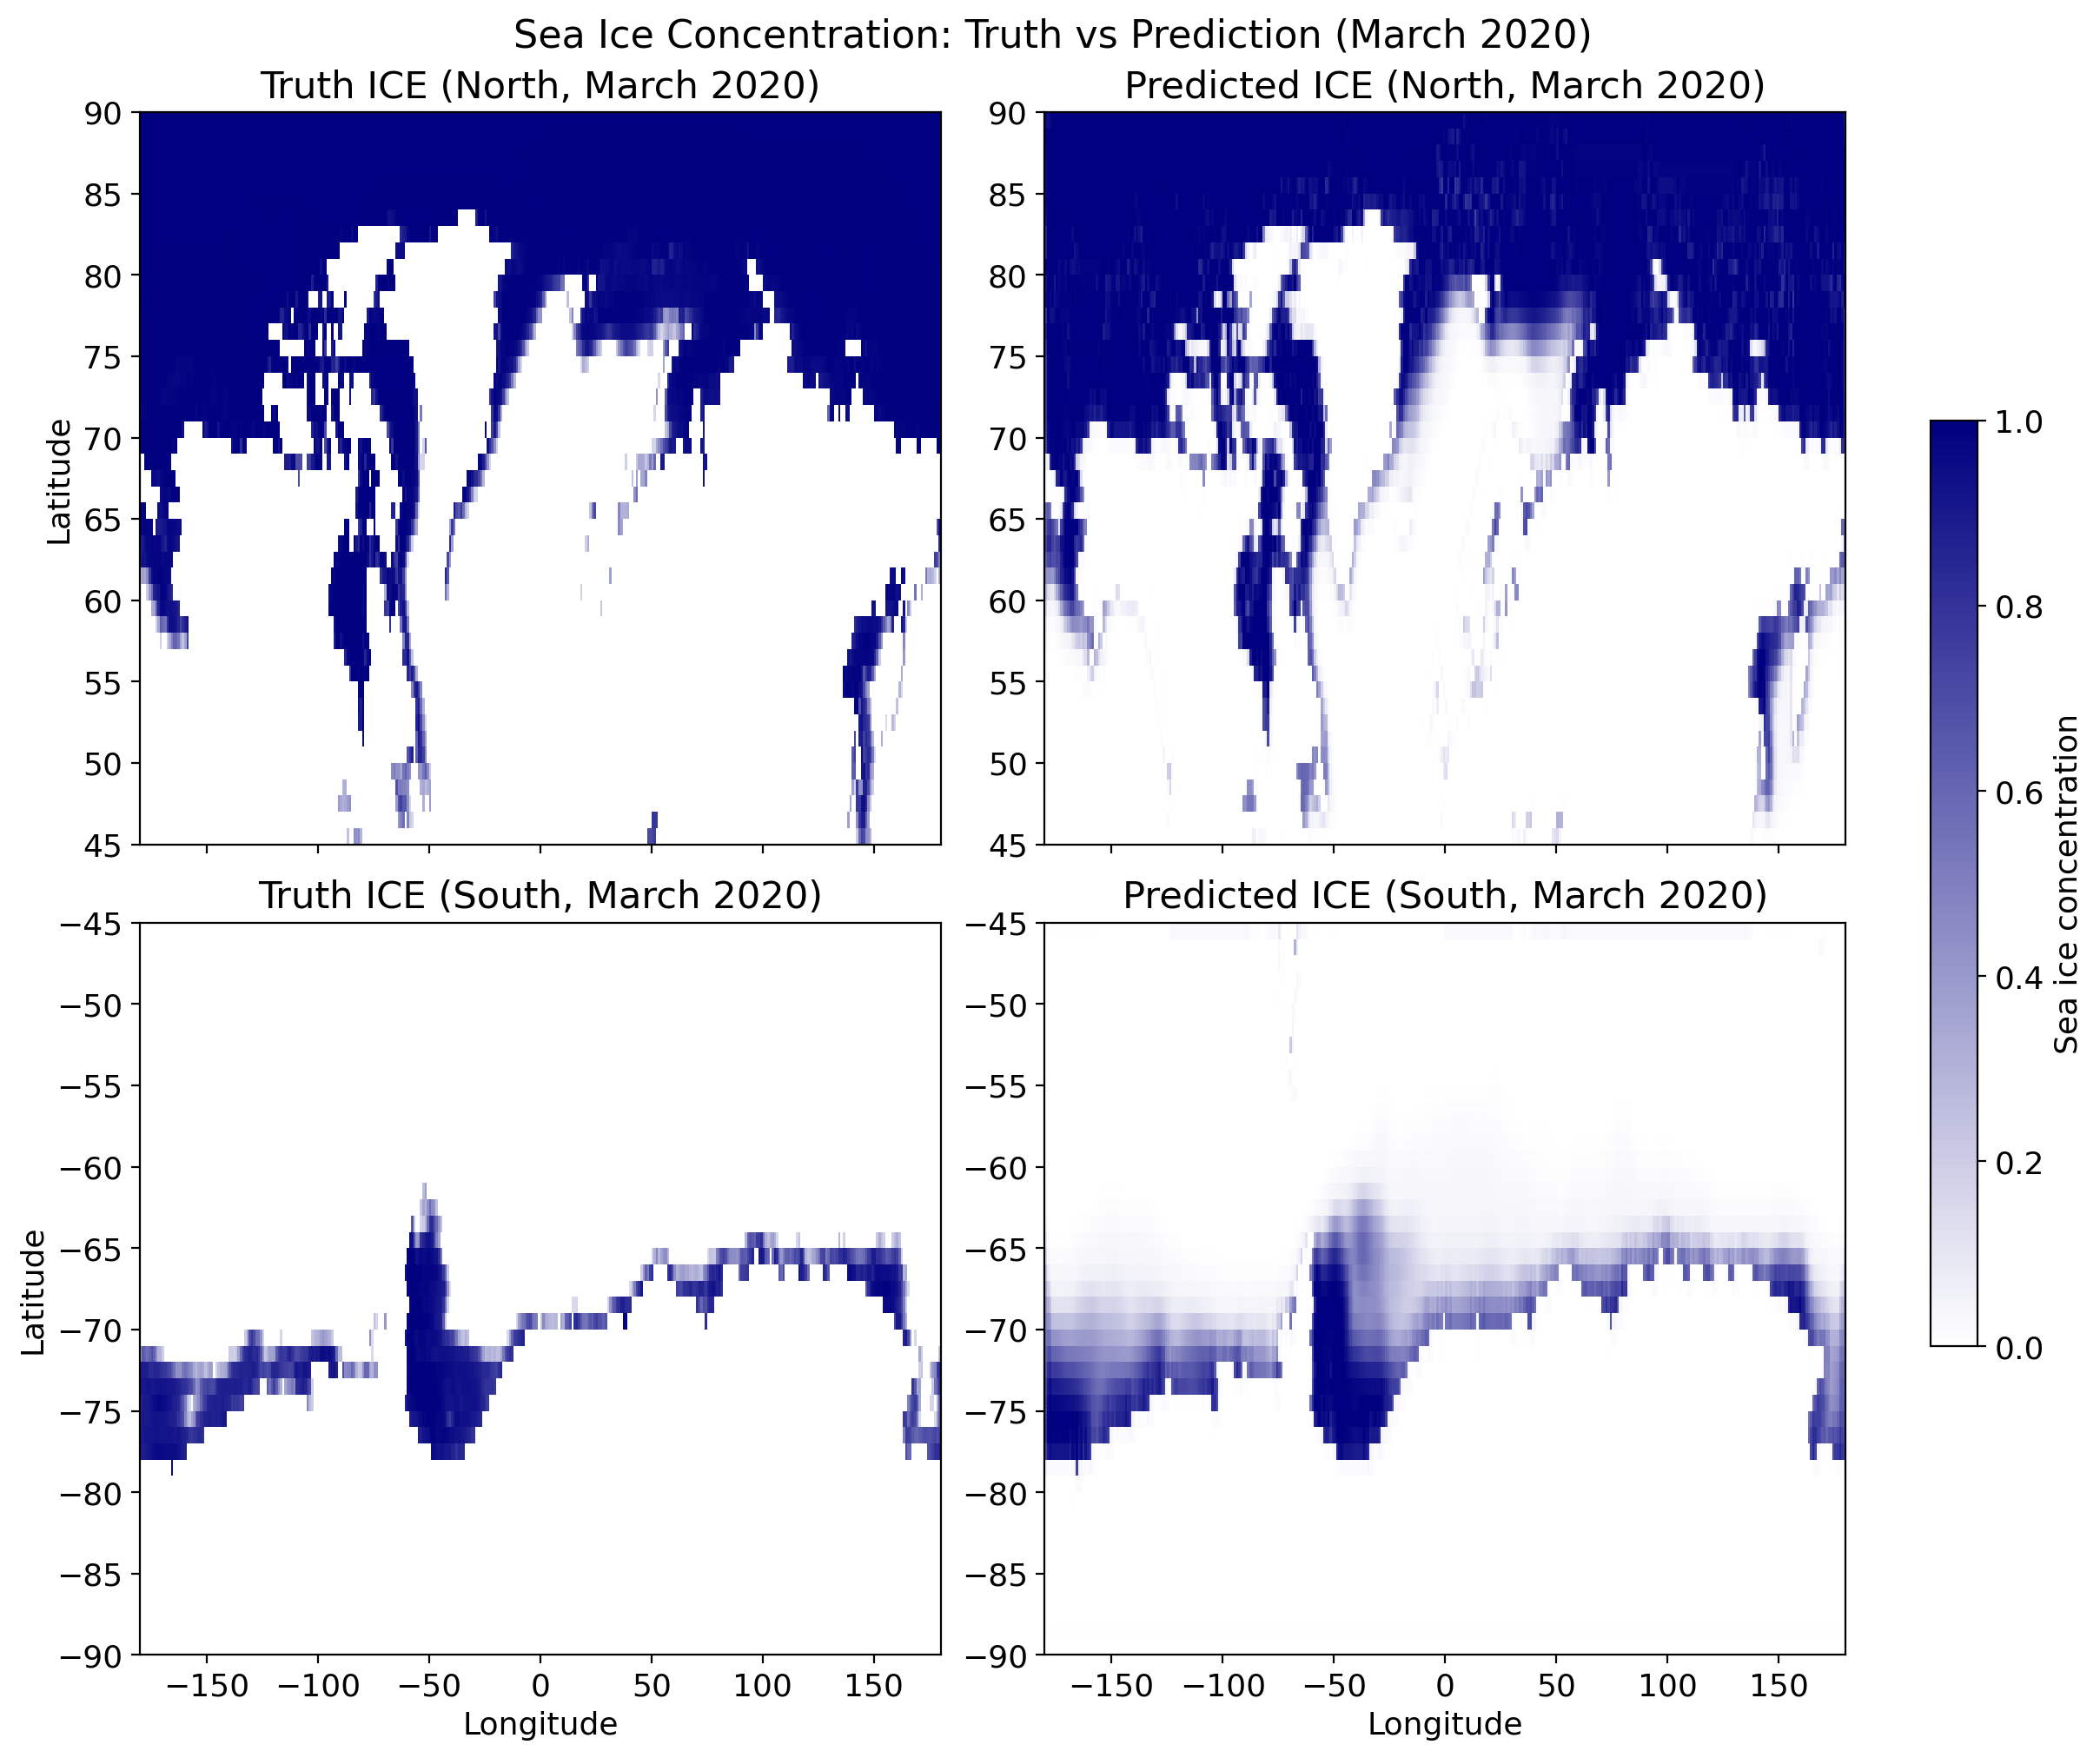

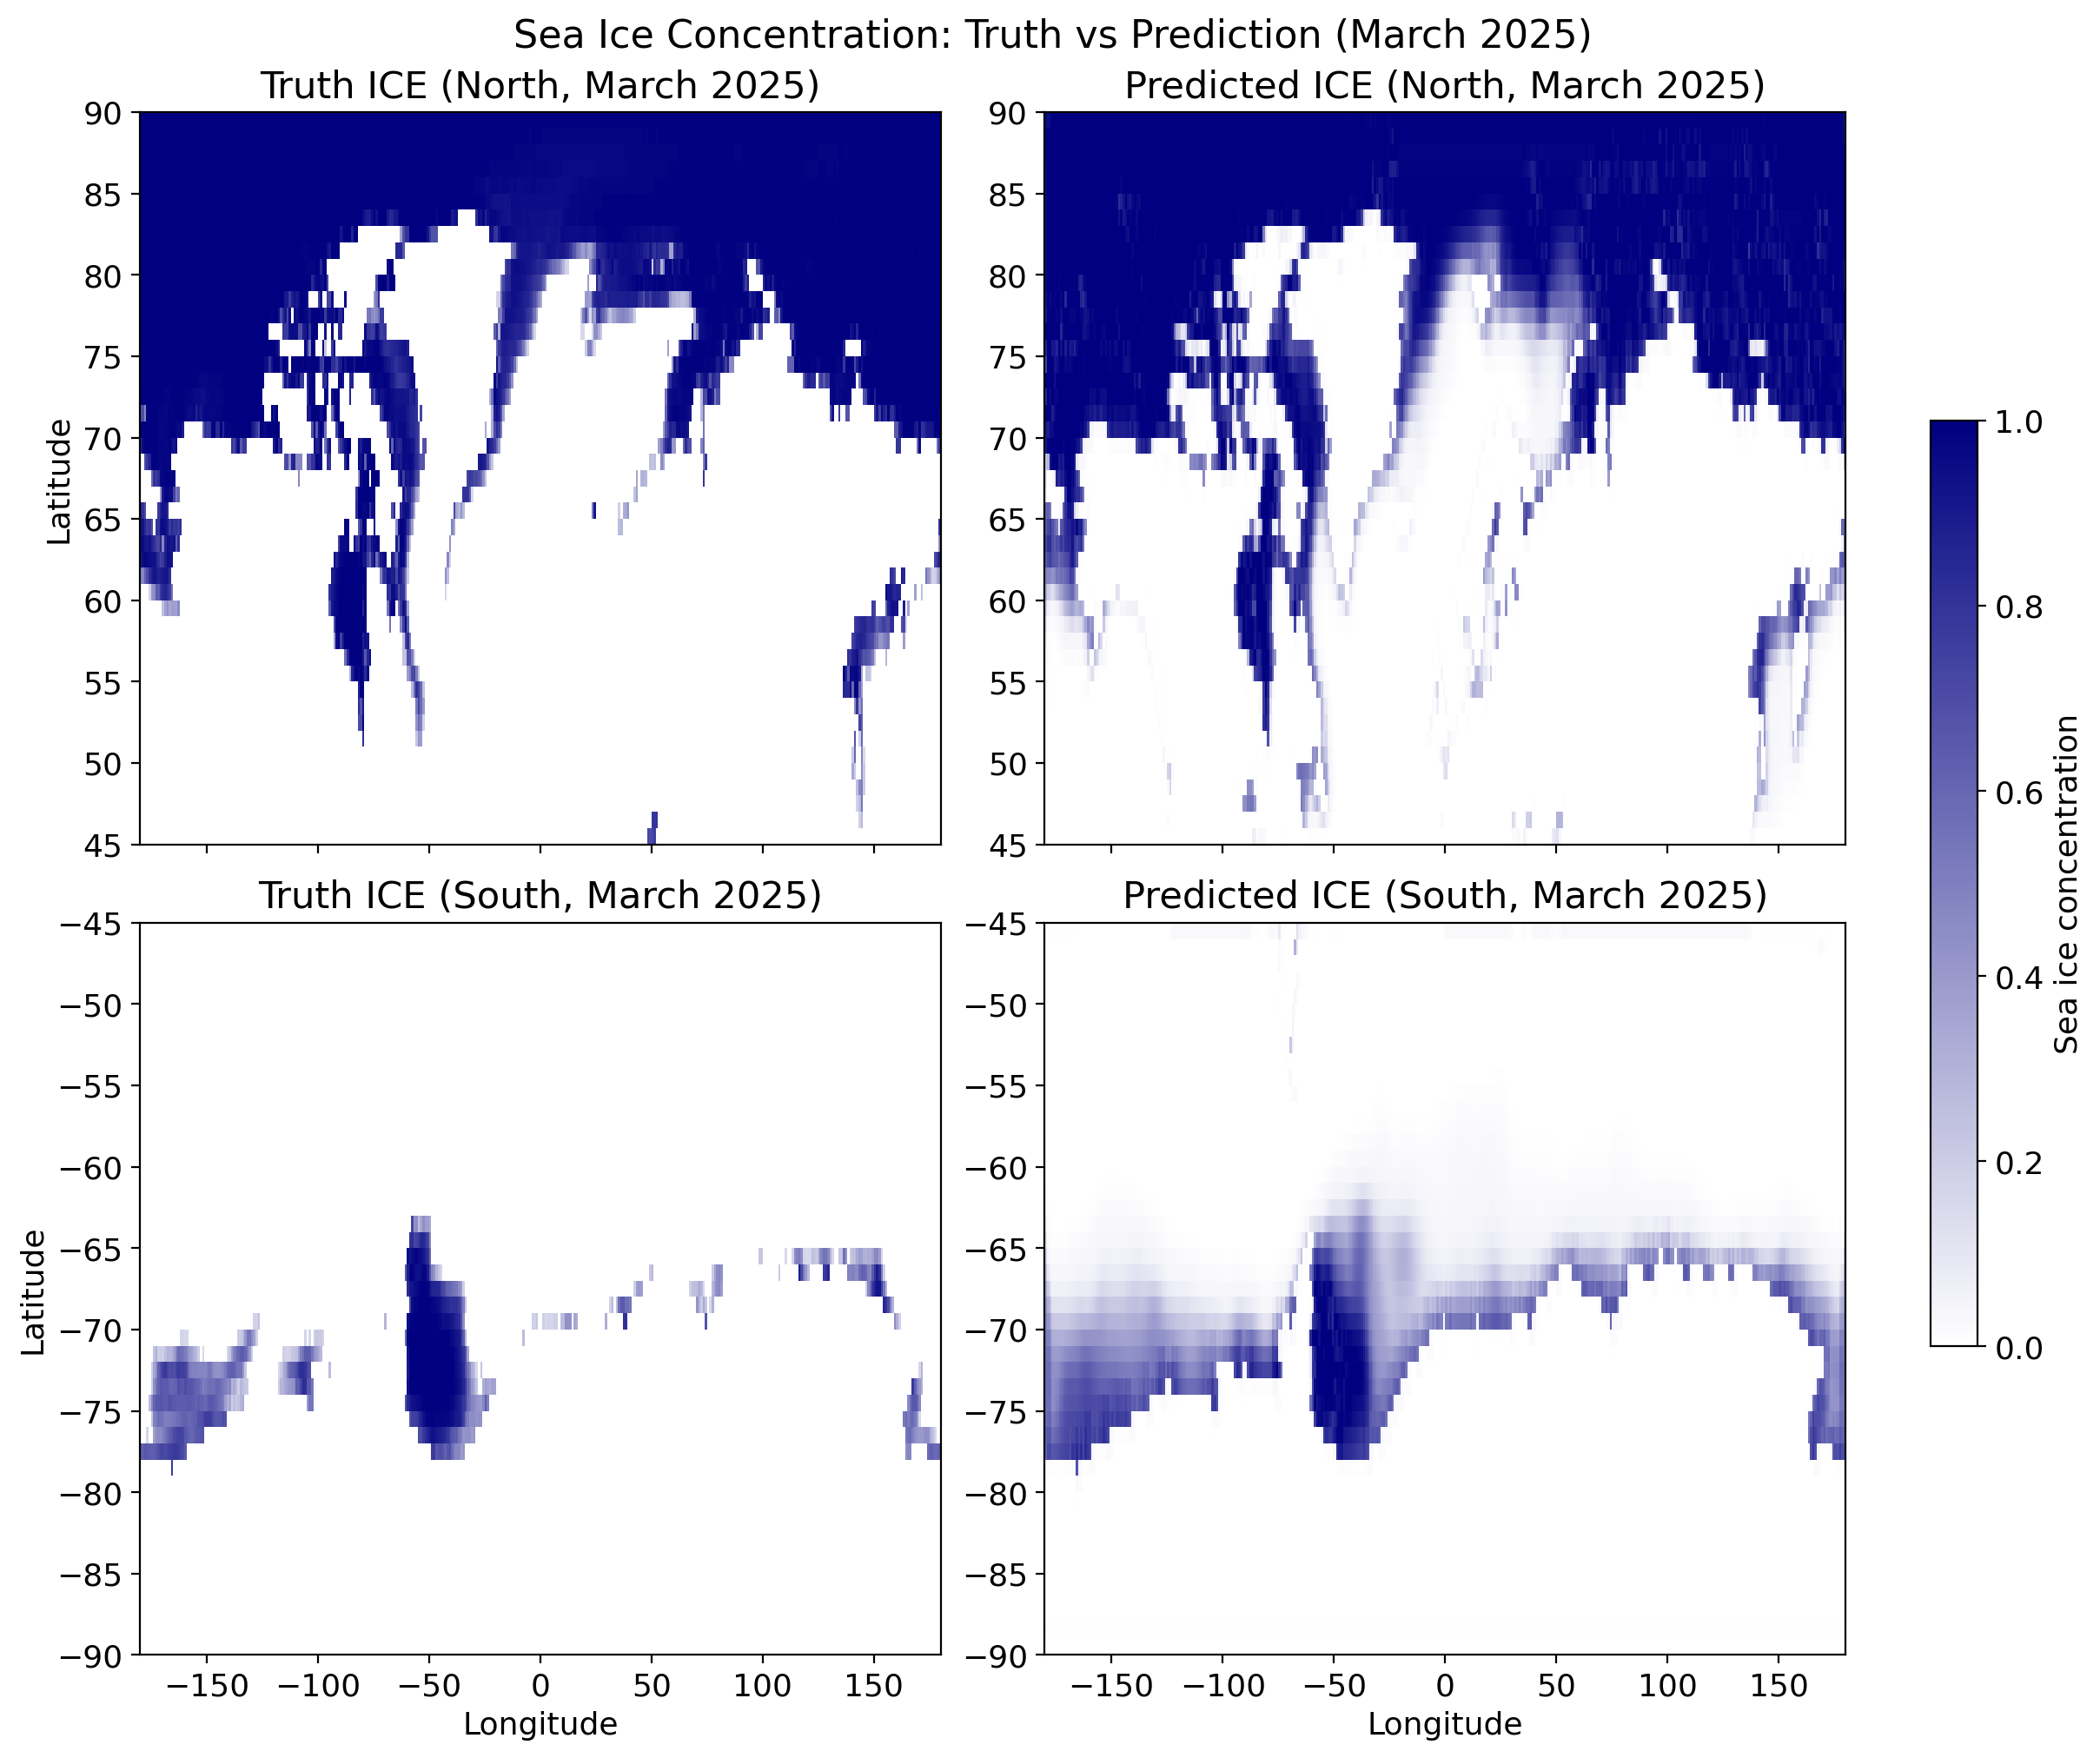

In [58]:
for yr in [2015, 2020, 2025]:
    plot_march_maps_polar_clean(
        year=yr,
        model=model_mse,
        X_data=X_test,
        y_data=y_test,
        ds_data=ds_test,
        lat=lat,
        lon=lon,
        device=device
    )


In [159]:
import torch
import numpy as np

def compute_rmse(model, X_test, y_test, device):
    model.eval()
    model.to(device)

    preds = []
    with torch.no_grad():
        for i in range(0, X_test.shape[0], minibatch_size):
            batch = torch.from_numpy(X_test[i:i+minibatch_size]).float().to(device)
            out = model(batch).cpu().numpy()
            preds.append(out)

    preds = np.concatenate(preds, axis=0)
    preds = preds.squeeze(1)
    truth = y_test.squeeze(1)

    rmse = np.sqrt(np.mean((preds - truth)**2))
    return rmse

rmse_value = compute_rmse(model_mse, X_test, y_test, device)
print("Overall Test RMSE:", rmse_value)


Overall Test RMSE: 0.0901657


In [160]:
import torch
import numpy as np

def compute_rmse_greenland(model, X_test, y_test, device, lat, lon):

    model.eval()
    model.to(device)

    preds = []
    with torch.no_grad():
        for i in range(0, X_test.shape[0], minibatch_size):
            batch = torch.from_numpy(X_test[i:i+minibatch_size]).float().to(device)
            out = model(batch).cpu().numpy()
            preds.append(out)

    preds = np.concatenate(preds, axis=0)
    preds = preds.squeeze(1)
    truth = y_test.squeeze(1)

    lat_arr = np.asarray(lat)
    lon_arr = np.asarray(lon)

    lat_min, lat_max = 60.0, 85.0

    if lon_arr.min() < 0 and lon_arr.max() <= 180:
        lon_min, lon_max = -75.0, -10.0
    else:
        lon_min, lon_max = (-75.0) % 360.0, (-10.0) % 360.0

    lat_mask = (lat_arr >= lat_min) & (lat_arr <= lat_max)
    lon_mask = (lon_arr >= lon_min) & (lon_arr <= lon_max)

    if not lat_mask.any() or not lon_mask.any():
        print("Greenland had no cells")
        print("  lat range in data:", float(lat_arr.min()), "to", float(lat_arr.max()))
        print("  lon range in data:", float(lon_arr.min()), "to", float(lon_arr.max()))
        return np.nan

    preds_gl = preds[:, lat_mask, :][:, :, lon_mask]
    truth_gl = truth[:, lat_mask, :][:, :, lon_mask]

    rmse = np.sqrt(np.nanmean((preds_gl - truth_gl) ** 2))
    return rmse



In [161]:
rmse_greenland = compute_rmse_greenland(
    model_mse,
    X_test,
    y_test,
    device,
    lat=lat,
    lon=lon
)

print("Greenland regional RMSE:", rmse_greenland)


Greenland regional RMSE: 0.1133596
